In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

balls_threshold = 50 #Change this number to change the minimum number of balls faced by a batsman

path = "/Users/samarth/Desktop/Plaksha/Dream 11 team prediction/IPL_Ball_by_Ball_2008_2022.csv"
df = pd.read_csv(path)

path = "/Users/samarth/Desktop/Plaksha/Dream 11 team prediction/IPL_Matches_2008_2022.csv"
df2 = pd.read_csv(path)

#Delhi Daredevils has been rebranded to Delhi Capitals, therefore both Delhi Daredevils and Delhi Capitals are saved as Delhi
#Rising Pune Supergiants had a typo in some of the columns and it was written as Rising Pune Supergiant. That has also been fixed

df2 = df2.replace({"Team1": {"Delhi Daredevils": "Delhi", "Delhi Capitals": "Delhi", "Rising Pune Supergiant": "Rising Pune Supergiants","Royal Challengers Bangalore":"Royal Challengers Bengaluru"},
                            "Team2": {"Delhi Daredevils": "Delhi", "Delhi Capitals": "Delhi", "Rising Pune Supergiant": "Rising Pune Supergiants","Royal Challengers Bangalore":"Royal Challengers Bengaluru"},
                            "WinningTeam": {"Delhi Daredevils": "Delhi", "Delhi Capitals": "Delhi", "Rising Pune Supergiant": "Rising Pune Supergiants","Royal Challengers Bangalore":"Royal Challengers Bengaluru"}})

df = df.replace({"BattingTeam": {"Delhi Daredevils": "Delhi", "Delhi Capitals": "Delhi", "Rising Pune Supergiant": "Rising Pune Supergiants"}})

#Dropping all rain affected matches or abandoned matches

counter = 0
indices = []
for i in df2['ID']:
    row = df2.loc[df2['ID'] == i].iloc[0]
    if pd.notna(row['method']) or row['WonBy'] == 'NoResults':
        counter += 1
        indices.append(i)


for i in indices:
    df = df[df['ID'] != i]
    df2 = df2[df2['ID'] != i]

ball_by_ball_df = df
matches_df = df2

bowlers = ball_by_ball_df['bowler'].unique()
bowling_averages_dict = {}

for bowler in bowlers:
    bowler_bowling = ball_by_ball_df[ball_by_ball_df['bowler'] == bowler]
    
    total_balls_bowled = len(bowler_bowling)
    
    total_runs_conceded = bowler_bowling['total_run'].sum()
    
    # Count the number of wickets taken by the bowler (excluding run outs, wickets taken on no balls, and wickets taken on free hits)
    wickets_mask = (bowler_bowling['player_out'].notna()) & (bowler_bowling['kind'] != 'run out') & (bowler_bowling['extra_type'] != 'noballs')
    freehit_mask = bowler_bowling['extra_type'].shift(1) == 'noballs'
    total_wickets = np.sum(wickets_mask & ~freehit_mask)
    
    #threshold is set at 200 minimum number of balls bowled
    if total_balls_bowled >= balls_threshold:
        # for bowling average
        if total_wickets > 0:
            bowling_average = total_runs_conceded / total_wickets
            bowling_averages_dict[bowler] = bowling_average

sorted_bowling_averages = sorted(bowling_averages_dict.items(), key=lambda x: x[1])
print("Bowling averages of bowlers who have bowled a minimum of 200 balls (in ascending order, excluding run outs, wickets taken on no balls, and wickets taken on free hits):")


sorted_bowling_averages = dict(sorted_bowling_averages)
bowling_averages_df = pd.DataFrame.from_dict(sorted_bowling_averages , orient='index', columns=['Average'])
bowling_averages_df['Average'] = (bowling_averages_df['Average'] - bowling_averages_df['Average'].mean()) * -1 / bowling_averages_df['Average'].std()


matches_df = df2
batsmen = ball_by_ball_df['batter'].unique()
averages_dict = {}

for batsman in batsmen:
    batsman_batting = ball_by_ball_df[ball_by_ball_df['batter'] == batsman]
    
    total_balls_faced = len(batsman_batting)
    
    # threshold at minimum 200 balls faced
    if total_balls_faced >= balls_threshold:
        match_stats = batsman_batting.groupby('ID').agg({'batsman_run': 'sum'}).reset_index()

        total_runs = match_stats['batsman_run'].sum()
        total_innings = len(match_stats)
        
        #number of dismissals for the batsman
        total_dismissals = np.sum(ball_by_ball_df['player_out'] == batsman)
        if total_dismissals > 0:
            overall_average = total_runs / total_dismissals
            averages_dict[batsman] = overall_average


batsmen_averages_df = pd.DataFrame.from_dict(averages_dict, orient='index', columns=['Average'])
batsmen_averages_df['Standardized Average'] = (batsmen_averages_df['Average'] - batsmen_averages_df['Average'].mean()) / batsmen_averages_df['Average'].std()

batsmen_averages_df = batsmen_averages_df.sort_values(by='Average', ascending=False)
print("Batting Averages and Standardized Averages for batsmen who have faced at least 200 balls:")


ball_by_ball_df = df
matches_df = df2

batsmen = ball_by_ball_df['batter'].unique()
strike_rates_dict = {}

for batsman in batsmen:
    batsman_batting = ball_by_ball_df[ball_by_ball_df['batter'] == batsman]
    
    # Count the total number of balls faced by the batsman (excluding wide and no balls)
    balls_faced = len(batsman_batting[(batsman_batting['extras_run'] == 0) | ((batsman_batting['extra_type'] != 'wides') & (batsman_batting['extra_type'] != 'noballs'))])
 
    if balls_faced >= balls_threshold:
        runs_scored = batsman_batting[batsman_batting['extra_type'] != 'legbyes']['batsman_run'].sum()
        strike_rate = (runs_scored * 100) / balls_faced
        strike_rates_dict[batsman] = strike_rate

strike_rates_df = pd.DataFrame.from_dict(strike_rates_dict, orient='index', columns=['Strike Rate'])
strike_rates_df = strike_rates_df.sort_values(by='Strike Rate', ascending=False)
print("Strike Rates (minimum 200 balls faced, excluding leg byes, wide, and no balls):")

strike_rates_df['Standardised'] = (strike_rates_df['Strike Rate'] - strike_rates_df['Strike Rate'].mean())/ strike_rates_df['Strike Rate'].std()





ball_by_ball_df = df
matches_df = df2


bowlers = ball_by_ball_df['bowler'].unique()
balls_per_wicket_dict = {}

for bowler in bowlers:
    bowler_bowling = ball_by_ball_df[ball_by_ball_df['bowler'] == bowler]

    total_balls_bowled = len(bowler_bowling)

    if total_balls_bowled >= balls_threshold:
        wickets_mask = (bowler_bowling['player_out'].notna()) & (bowler_bowling['kind'] != 'run out') & (bowler_bowling['extra_type'] != 'noballs')

        freehit_mask = bowler_bowling['extra_type'].shift(1) == 'noballs'

        total_wickets = wickets_mask[~freehit_mask].sum()
        if total_wickets > 0:
            balls_per_wicket = total_balls_bowled / total_wickets
            balls_per_wicket_dict[bowler] = balls_per_wicket

balls_per_wicket_df = pd.DataFrame.from_dict(balls_per_wicket_dict, orient='index', columns=['Balls per Wicket'])

balls_per_wicket_df = balls_per_wicket_df.sort_values(by='Balls per Wicket')

print("Balls per Wicket (minimum 200 balls bowled):")


balls_per_wicket_df['Standardised'] = (balls_per_wicket_df['Balls per Wicket'] - balls_per_wicket_df['Balls per Wicket'].mean()) * -1 / balls_per_wicket_df['Balls per Wicket'].std()

ball_by_ball_df = df
matches_df = df2

batsmen = ball_by_ball_df['batter'].unique()

avg_balls_faced_dict = {}

for batsman in batsmen:
    batsman_batting = ball_by_ball_df[ball_by_ball_df['batter'] == batsman]

    innings_played = batsman_batting['ID'].nunique()

    balls_faced = len(batsman_batting[(batsman_batting['extras_run'] == 0) | ((batsman_batting['extra_type'] != 'wides') & (batsman_batting['extra_type'] != 'noballs'))])

    if balls_faced >= balls_threshold:
        avg_balls_faced = balls_faced / innings_played
        avg_balls_faced_dict[batsman] = avg_balls_faced

avg_balls_faced_df = pd.DataFrame.from_dict(avg_balls_faced_dict, orient='index', columns=['Average Balls Faced'])

avg_balls_faced_df = avg_balls_faced_df.sort_values(by='Average Balls Faced', ascending=False)

print("Average Balls Faced (minimum 200 balls faced, excluding wide and no balls):")

avg_balls_faced_df['Standardised'] = (avg_balls_faced_df['Average Balls Faced'] - avg_balls_faced_df['Average Balls Faced'].mean())/ avg_balls_faced_df['Average Balls Faced'].std()

ball_by_ball_df = df
matches_df = df2
batsmen = ball_by_ball_df['batter'].unique()

centuries_dict = {}
for batsman in batsmen:
    batsman_batting = ball_by_ball_df[ball_by_ball_df['batter'] == batsman]
    match_runs = batsman_batting.groupby('ID')['batsman_run'].sum()
    centuries = len(match_runs[match_runs >= 100])
    
    if centuries > 0:
        centuries_dict[batsman] = centuries

centuries_df = pd.DataFrame.from_dict(centuries_dict, orient='index', columns=['centuries'])
centuries_df = centuries_df.sort_values(by='centuries', ascending=False)

print("Number of Centuries for each batsman:")
centuries_df['Standardised'] = (centuries_df ['centuries'] - centuries_df['centuries'].mean())/ centuries_df['centuries'].std()

ball_by_ball_df = df
matches_df = df2

batsmen = ball_by_ball_df['batter'].unique()
half_centuries_dict = {}

for batsman in batsmen:
    batsman_batting = ball_by_ball_df[ball_by_ball_df['batter'] == batsman]
    match_runs = batsman_batting.groupby('ID')['batsman_run'].sum()
    half_centuries = len(match_runs[(match_runs >= 50) & (match_runs < 100)])
    if half_centuries >= 1:
        half_centuries_dict[batsman] = half_centuries

half_centuries_df = pd.DataFrame.from_dict(half_centuries_dict, orient='index', columns=['Half-Centuries'])
half_centuries_df = half_centuries_df.sort_values(by='Half-Centuries', ascending=False)
print("Number of Half-Centuries for batsmen with a minimum of 1 half-century:")

half_centuries_df['Standardised'] = (half_centuries_df['Half-Centuries'] - half_centuries_df['Half-Centuries'].mean())/ half_centuries_df['Half-Centuries'].std()

ball_by_ball_df = df
matches_df = df2

batsmen = ball_by_ball_df['batter'].unique()
fours_per_innings_dict = {}

for batsman in batsmen:
    batsman_batting = ball_by_ball_df[ball_by_ball_df['batter'] == batsman]
    balls_faced = len(batsman_batting)

    if balls_faced >= balls_threshold:
        innings_played = batsman_batting['ID'].nunique()
    
        total_fours = batsman_batting[batsman_batting['batsman_run'] == 4].shape[0]
        fours_per_innings = total_fours / innings_played
        fours_per_innings_dict[batsman] = fours_per_innings

fours_per_innings_df = pd.DataFrame.from_dict(fours_per_innings_dict, orient='index', columns=['4s per Innings'])
fours_per_innings_df = fours_per_innings_df.sort_values(by='4s per Innings', ascending=False)

print("Average number of 4's per innings for batsmen:")

fours_per_innings_df['Standardised'] = (fours_per_innings_df['4s per Innings'] - fours_per_innings_df['4s per Innings'].mean())/ fours_per_innings_df['4s per Innings'].std()

matches_df = df2

batsmen = ball_by_ball_df['batter'].unique()

sixes_per_innings_dict = {}

for batsman in batsmen:
    batsman_batting = ball_by_ball_df[ball_by_ball_df['batter'] == batsman]
    balls_faced = len(batsman_batting)

    if balls_faced >= balls_threshold:
        innings_played = batsman_batting['ID'].nunique()
        total_sixes = batsman_batting[batsman_batting['batsman_run'] == 6].shape[0]
        sixes_per_innings = total_sixes / innings_played
        
        sixes_per_innings_dict[batsman] = sixes_per_innings

sixes_per_innings_df = pd.DataFrame.from_dict(sixes_per_innings_dict, orient='index', columns=['6s per Innings'])
sixes_per_innings_df = sixes_per_innings_df.sort_values(by='6s per Innings', ascending=False)
print("Average number of 6's per innings for batsmen with a minimum of 200 balls faced:")

sixes_per_innings_df['Standardised'] = (sixes_per_innings_df['6s per Innings'] - sixes_per_innings_df['6s per Innings'].mean())/ sixes_per_innings_df['6s per Innings'].std()


ball_by_ball_df = df
matches_df = df2
batsmen = ball_by_ball_df['batter'].unique()
dot_ball_percentage_dict = {}

for batsman in batsmen:
    batsman_batting = ball_by_ball_df[ball_by_ball_df['batter'] == batsman]
    balls_faced = len(batsman_batting)
    
    if balls_faced >= balls_threshold:
        dot_balls = len(batsman_batting[batsman_batting['batsman_run'] == 0])
        dot_ball_percentage = (dot_balls / balls_faced) * 100
        
        dot_ball_percentage_dict[batsman] = dot_ball_percentage

dot_ball_percentage_df = pd.DataFrame.from_dict(dot_ball_percentage_dict, orient='index', columns=['Dot Ball Percentage'])
dot_ball_percentage_df = dot_ball_percentage_df.sort_values(by='Dot Ball Percentage', ascending=True)
print("Dot Ball Percentage for batsmen with a minimum of 200 balls faced:")

dot_ball_percentage_df['Standardised'] = (dot_ball_percentage_df['Dot Ball Percentage'] - dot_ball_percentage_df['Dot Ball Percentage'].mean()) * -1/ dot_ball_percentage_df['Dot Ball Percentage'].std()
dot_ball_percentage_batsman_df = dot_ball_percentage_df



ball_by_ball_df = df
matches_df = df2

bowlers = ball_by_ball_df['bowler'].unique()
wickets_taken_per_game_dict = {}

for bowler in bowlers:
    bowler_bowling = ball_by_ball_df[ball_by_ball_df['bowler'] == bowler]

    balls_bowled = len(bowler_bowling)
    if balls_bowled >= balls_threshold:
        games_played = bowler_bowling['ID'].nunique()
        wickets_taken = bowler_bowling['player_out'].notna().sum()
        wickets_taken_per_game = wickets_taken / games_played
        
        wickets_taken_per_game_dict[bowler] = wickets_taken_per_game
        
wickets_taken_per_game_df = pd.DataFrame.from_dict(wickets_taken_per_game_dict, orient='index', columns=['Wickets Taken per Game'])
wickets_taken_per_game_df = wickets_taken_per_game_df.sort_values(by='Wickets Taken per Game', ascending=False)
print("Wickets Taken per Game for bowlers with a minimum of 200 balls bowled:")

wickets_taken_per_game_df['Standardised'] = (wickets_taken_per_game_df['Wickets Taken per Game'] - wickets_taken_per_game_df['Wickets Taken per Game'].mean()) / wickets_taken_per_game_df ['Wickets Taken per Game'].std()


ball_by_ball_df = df
matches_df = df2

bowlers = ball_by_ball_df['bowler'].unique()
runs_given_per_over_dict = {}

for bowler in bowlers:
    bowler_bowling = ball_by_ball_df[ball_by_ball_df['bowler'] == bowler]
    balls_bowled = len(bowler_bowling)

    if balls_bowled >= balls_threshold:
        game_stats = bowler_bowling.groupby('ID').agg({'total_run': 'sum', 'bowler': 'count'})
    
        total_runs_given = game_stats['total_run'].sum()
        total_overs_bowled = game_stats['bowler'].sum() // 6  
        runs_given_per_over = total_runs_given / total_overs_bowled        
        runs_given_per_over_dict[bowler] = runs_given_per_over

runs_given_per_over_df = pd.DataFrame.from_dict(runs_given_per_over_dict, orient='index', columns=['Runs Given per Over'])
runs_given_per_over_df = runs_given_per_over_df.sort_values(by='Runs Given per Over')

print("Runs Given per Over for bowlers(economy) with a minimum of 200 balls bowled:")

runs_given_per_over_df['Standardised'] = (runs_given_per_over_df['Runs Given per Over'] - runs_given_per_over_df['Runs Given per Over'].mean()) * -1/ runs_given_per_over_df['Runs Given per Over'].std()


ball_by_ball_df = df
matches_df = df2
bowlers = ball_by_ball_df['bowler'].unique()

dot_ball_percentage_dict = {}

for bowler in bowlers:
    bowler_bowling = ball_by_ball_df[ball_by_ball_df['bowler'] == bowler]
    
    total_balls = len(bowler_bowling)
    if total_balls >= balls_threshold:
        dot_balls = len(bowler_bowling[(bowler_bowling['total_run'] == 0) & (bowler_bowling['extra_type'] != 'wides') & (bowler_bowling['extra_type'] != 'noballs')])
        dot_ball_percentage = (dot_balls / total_balls) * 100
        dot_ball_percentage_dict[bowler] = dot_ball_percentage

dot_ball_percentage_df = pd.DataFrame.from_dict(dot_ball_percentage_dict, orient='index', columns=['Dot Ball Percentage'])
dot_ball_percentage_df = dot_ball_percentage_df.sort_values(by='Dot Ball Percentage', ascending=False)

print("Dot Ball Percentage for bowlers with a minimum of  (excluding wides and no balls):")

dot_ball_percentage_df['Standardised'] = (dot_ball_percentage_df['Dot Ball Percentage'] - dot_ball_percentage_df['Dot Ball Percentage'].mean()) / dot_ball_percentage_df['Dot Ball Percentage'].std()


ball_by_ball_df = df
matches_df = df2

bowlers = ball_by_ball_df['bowler'].unique()
sixes_percentage_dict = {}

for bowler in bowlers:
    bowler_bowling = ball_by_ball_df[ball_by_ball_df['bowler'] == bowler]
    total_balls = len(bowler_bowling)
    if total_balls >= balls_threshold:
        sixes_per_over = bowler_bowling[bowler_bowling['batsman_run'] == 6].groupby(['ID', 'overs']).size()
        total_overs = total_balls // 6
        sixes_percentage = (sixes_per_over.sum() / total_overs)
        sixes_percentage_dict[bowler] = sixes_percentage

sixes_percentage_df = pd.DataFrame.from_dict(sixes_percentage_dict, orient='index', columns=['Sixes per Over'])
sixes_percentage_df = sixes_percentage_df.sort_values(by='Sixes per Over')

print("Sixes Conceded per Over for bowlers with a minimum of 200 balls bowled:")

sixes_percentage_df['Standardised'] = (sixes_percentage_df['Sixes per Over'] - sixes_percentage_df['Sixes per Over'].mean()) * -1 / sixes_percentage_df['Sixes per Over'].std()

ball_by_ball_df = df
matches_df = df2
bowlers = ball_by_ball_df['bowler'].unique()
fours_percentage_dict = {}

for bowler in bowlers:
    bowler_bowling = ball_by_ball_df[ball_by_ball_df['bowler'] == bowler]
    total_balls = len(bowler_bowling)
    
    if total_balls >= balls_threshold:
        fours_per_over = bowler_bowling[bowler_bowling['batsman_run'] == 4].groupby(['ID', 'overs']).size()
        total_overs = total_balls // 6
        fours_percentage = (fours_per_over.sum() / total_overs)
        
        fours_percentage_dict[bowler] = fours_percentage

fours_percentage_df = pd.DataFrame.from_dict(fours_percentage_dict, orient='index', columns=['Fours per Over'])
fours_percentage_df = fours_percentage_df.sort_values(by='Fours per Over')

print("Fours Conceded per Over for bowlers with a minimum of 200 balls bowled:")
fours_percentage_df['Standardised'] = (fours_percentage_df['Fours per Over'] - fours_percentage_df['Fours per Over'].mean()) * -1 / fours_percentage_df['Fours per Over'].std()



ball_by_ball_df = df
bowlers = ball_by_ball_df['bowler'].unique()
avg_overs_per_match_dict = {}

for bowler in bowlers:
    match_ids_bowled = ball_by_ball_df[ball_by_ball_df['bowler'] == bowler]['ID'].unique()
    match_ids_played = ball_by_ball_df[ball_by_ball_df['batter'] == bowler]['ID'].unique()
    match_ids = np.union1d(match_ids_bowled, match_ids_played)   
    total_matches_played = len(match_ids)
    total_overs_bowled = 0

    for match_id in match_ids_bowled:
        balls_bowled = len(ball_by_ball_df[(ball_by_ball_df['bowler'] == bowler) & (ball_by_ball_df['ID'] == match_id)])
        
        overs_bowled = balls_bowled // 6
        total_overs_bowled += overs_bowled
    
    if total_overs_bowled > 32:
        avg_overs_per_match = total_overs_bowled / total_matches_played
        avg_overs_per_match_dict[bowler] = avg_overs_per_match

avg_overs_per_match_df = pd.DataFrame.from_dict(avg_overs_per_match_dict, orient='index', columns=['Average Overs per Match'])
avg_overs_per_match_df = avg_overs_per_match_df.sort_values(by='Average Overs per Match', ascending=False)
print("Average Overs Bowled per Match for bowlers who have bowled more than 32 overs:")

avg_overs_per_match_df['Standardised'] = (avg_overs_per_match_df['Average Overs per Match'] - avg_overs_per_match_df['Average Overs per Match'].mean()) / avg_overs_per_match_df['Average Overs per Match'].std()



ball_by_ball_df = df
batsmen = ball_by_ball_df['batter'].unique()
boundary_freq_batsman_dict = {}

for batsman in batsmen:
    batsman_balls = ball_by_ball_df[ball_by_ball_df['batter'] == batsman]
    total_balls_faced = len(batsman_balls)
    fours_hit = len(batsman_balls[batsman_balls['batsman_run'] == 4])
    sixes_hit = len(batsman_balls[batsman_balls['batsman_run'] == 6])
    
    if total_balls_faced >= balls_threshold:
        boundary_freq = (fours_hit + sixes_hit) / total_balls_faced
    
        boundary_freq_batsman_dict[batsman] = boundary_freq
        
boundary_freq_batsman_df = pd.DataFrame.from_dict(boundary_freq_batsman_dict, orient='index', columns=['Boundary Frequency'])
boundary_freq_batsman_df = boundary_freq_batsman_df.sort_values(by='Boundary Frequency', ascending=False)

print("Boundary Frequency for each batsman:")

boundary_freq_batsman_df['Standardised'] = (boundary_freq_batsman_df['Boundary Frequency'] - boundary_freq_batsman_df['Boundary Frequency'].mean()) / boundary_freq_batsman_df['Boundary Frequency'].std()


import pandas as pd
import numpy as np

ball_by_ball_df = df
bowlers = ball_by_ball_df['bowler'].unique()
boundary_freq_bowler_dict = {}

for bowler in bowlers:
    bowler_balls = ball_by_ball_df[ball_by_ball_df['bowler'] == bowler]
    total_balls_bowled = len(bowler_balls)
    fours_conceded = len(bowler_balls[bowler_balls['batsman_run'] == 4])
    sixes_conceded = len(bowler_balls[bowler_balls['batsman_run'] == 6])
    if total_balls_bowled >= balls_threshold:
        boundary_freq = (fours_conceded + sixes_conceded) / total_balls_bowled
        
        boundary_freq_bowler_dict[bowler] = boundary_freq

boundary_freq_bowler_df = pd.DataFrame.from_dict(boundary_freq_bowler_dict, orient='index', columns=['Boundary Frequency'])
boundary_freq_bowler_df = boundary_freq_bowler_df.sort_values(by='Boundary Frequency')

print("Boundary Frequency for each bowler:")

boundary_freq_bowler_df['Standardised'] = (boundary_freq_bowler_df['Boundary Frequency'] - boundary_freq_bowler_df['Boundary Frequency'].mean()) * -1 / boundary_freq_bowler_df['Boundary Frequency'].std()

# List of DataFrames with clear naming
dfs = [
    (batsmen_averages_df['Standardized Average'], 'Batting Average'),
    (strike_rates_df['Standardised'], 'Strike Rate'),
    (avg_balls_faced_df['Standardised'], 'Avg Balls Faced'),
    (centuries_df['Standardised'], 'Centuries'),
    (half_centuries_df['Standardised'], 'Half Centuries'),
    (fours_per_innings_df['Standardised'], 'Fours per Innings'),
    (sixes_per_innings_df['Standardised'], 'Sixes per Innings'),
    (dot_ball_percentage_df['Standardised'], 'Dot Ball % Batting'),
    (bowling_averages_df['Average'], 'Bowling Average'),
    (balls_per_wicket_df['Standardised'], 'Balls per Wicket'),
    (wickets_taken_per_game_df['Standardised'], 'Wickets per Game'),
    (runs_given_per_over_df['Standardised'], 'Economy Rate'),
    (sixes_percentage_df['Standardised'], 'Sixes Conceded'),
    (fours_percentage_df['Standardised'], 'Fours Conceded'),
    (avg_overs_per_match_df['Standardised'], 'Overs per Match'),
    (boundary_freq_batsman_df['Standardised'], 'Boundary Freq Batting'),
    (boundary_freq_bowler_df['Standardised'], 'Boundary Freq Bowling')
]

# Create dictionary with named series
named_series = {name: df for df, name in dfs}

# Concatenate with outer join
merged_df = pd.concat(named_series, axis=1).fillna(0)

print(f"Number of players in dataset: {len(merged_df)}")
print("\nFirst few rows of the merged dataset:")
print(merged_df.head())

In [ ]:
#This is a dictionary containing the role of each player
cricket_players = {
    'YBK Jaiswal': 'BAT',
    'JC Buttler': 'WK',
    'SV Samson': 'WK',
    'D Padikkal': 'BAT',
    'SO Hetmyer': 'BAT',
    'R Ashwin': 'AR',
    'R Parag': 'AR',
    'TA Boult': 'BWL',
    'OC McCoy': 'BWL',
    'WP Saha': 'WK',
    'Shubman Gill': 'BAT',
    'MS Wade': 'WK',
    'HH Pandya': 'AR',
    'DA Miller': 'BAT',
    'V Kohli': 'BAT',
    'F du Plessis': 'BAT',
    'RM Patidar': 'BAT',
    'GJ Maxwell': 'AR',
    'MK Lomror': 'AR',
    'KD Karthik': 'WK',
    'Shahbaz Ahmed': 'AR',
    'PWH de Silva': 'AR',
    'HV Patel': 'BWL',
    'JR Hazlewood': 'BWL',
    'Q de Kock': 'WK',
    'KL Rahul': 'WK',
    'M Vohra': 'BAT',
    'DJ Hooda': 'AR',
    'MP Stoinis': 'AR',
    'E Lewis': 'BAT',
    'KH Pandya': 'AR',
    'PVD Chameera': 'BWL',
    'PK Garg': 'BAT',
    'Abhishek Sharma': 'AR',
    'RA Tripathi': 'BAT',
    'AK Markram': 'AR',
    'N Pooran': 'WK',
    'Washington Sundar': 'AR',
    'R Shepherd': 'AR',
    'J Suchith': 'BWL',
    'B Kumar': 'BWL',
    'Umran Malik': 'BWL',
    'JM Bairstow': 'WK',
    'S Dhawan': 'BAT',
    'M Shahrukh Khan': 'BAT',
    'MA Agarwal': 'BAT',
    'LS Livingstone': 'AR',
    'JM Sharma': 'BWL',
    'PN Mankad': 'AR',
    'PP Shaw': 'BAT',
    'DA Warner': 'BAT',
    'MR Marsh': 'AR',
    'RR Pant': 'WK',
    'SN Khan': 'BAT',
    'R Powell': 'BAT',
    'AR Patel': 'AR',
    'SN Thakur': 'BWL',
    'Kuldeep Yadav': 'BWL',
    'Ishan Kishan': 'WK',
    'RG Sharma': 'BAT',
    'D Brevis': 'BAT',
    'Tilak Varma': 'BAT',
    'TH David': 'BAT',
    'Ramandeep Singh': 'AR',
    'DR Sams': 'AR',
    'RD Gaikwad': 'BAT',
    'DP Conway': 'BAT',
    'MM Ali': 'AR',
    'N Jagadeesan': 'WK',
    'AT Rayudu': 'BAT',
    'MS Dhoni': 'WK',
    'Simarjeet Singh': 'BWL',
    'MJ Santner': 'AR',
    'R Tewatia': 'AR',
    'Rashid Khan': 'AR',
    'VR Iyer': 'BAT',
    'N Rana': 'BAT',
    'A Tomar': 'BAT',
    'SS Iyer': 'BAT',
    'SW Billings': 'WK',
    'AD Russell': 'AR',
    'RK Singh': 'BAT',
    'SP Narine': 'AR',
    'UT Yadav': 'BWL',
    'KS Williamson': 'BAT',
    'T Stubbs': 'BAT',
    'R Sanjay Yadav': 'AR',
    'JJ Bumrah': 'BWL',
    'Lalit Yadav': 'AR',
    'PBB Rajapaksa': 'BAT',
    'Harpreet Brar': 'BWL',
    'R Dhawan': 'BWL',
    'RD Chahar': 'BWL',
    'K Rabada': 'BWL',
    'Arshdeep Singh': 'BWL',
    'JDS Neesham': 'AR',
    'A Badoni': 'BAT',
    'JO Holder': 'AR',
    'Mohsin Khan': 'BWL',
    'Avesh Khan': 'BWL',
    'S Dube': 'AR',
    'AM Rahane': 'BAT',
    'Shashank Singh': 'BAT',
    'M Jansen': 'BWL',
    'Mohammed Siraj': 'BWL',
    'RV Uthappa': 'WK',
    'DJ Bravo': 'AR',
    'M Theekshana': 'BWL',
    'Mukesh Choudhary': 'BWL',
    'HR Shokeen': 'AR',
    'HE van der Dussen': 'BAT',
    'KS Bharat': 'WK',
    'KS Sharma': 'AR',
    'SP Jackson': 'WK',
    'PJ Cummins': 'BWL',
    'TG Southee': 'BWL',
    'KA Pollard': 'AR',
    'M Ashwin': 'BWL',
    'K Kartikeya': 'BWL',
    'RP Meredith': 'BWL',
    'RV Patel': 'BWL',
    'A Nortje': 'BWL',
    'KK Ahmed': 'BWL',
    'Kartik Tyagi': 'BWL',
    'Fazalhaq Farooqi': 'BWL',
    'B Indrajith': 'BAT',
    'AJ Finch': 'BAT',
    'AS Roy': 'BAT',
    'Shivam Mavi': 'AR',
    'Harshit Rana': 'BWL',
    'SA Yadav': 'BAT',
    'B Sai Sudharsan': 'BAT',
    'Mandeep Singh': 'BAT',
    'SA Abbott': 'BWL',
    'S Gopal': 'AR',
    'RA Jadeja': 'AR',
    'D Pretorius': 'AR',
    'PJ Sangwan': 'BWL',
    'LH Ferguson': 'BWL',
    'AS Joseph': 'BWL',
    'KK Nair': 'BAT',
    'DJ Mitchell': 'AR',
    'A Manohar': 'BAT',
    'M Prasidh Krishna': 'BWL',
    'SS Prabhudessai': 'BAT',
    'MK Pandey': 'BAT',
    'JD Unadkat': 'BWL',
    'Anuj Rawat': 'WK',
    'Yash Dayal': 'BWL',
    'NT Ellis': 'BWL',
    'VG Arora': 'BWL',
    'Ravi Bishnoi': 'BWL',
    'CV Varun': 'BWL',
    'V Shankar': 'AR',
    'P Simran Singh': 'WK',
    'OF Smith': 'BWL',
    'FA Allen': 'AR',
    'TS Mills': 'BWL',
    'Aman Hakim Khan': 'BAT',
    'YS Chahal': 'BWL',
    'KR Sen': 'BWL',
    'Akash Deep': 'BWL',
    'K Gowtham': 'AR',
    'Rasikh Salam': 'BWL',
    'CJ Jordan': 'BWL',
    'DJ Willey': 'AR',
    'SE Rutherford': 'AR',
    'Abdul Samad': 'BAT',
    'TL Seifert': 'WK',
    'Mustafizur Rahman': 'BWL',
    'Navdeep Saini': 'BWL',
    'Anmolpreet Singh': 'BAT',
    'RA Bawa': 'AR',
    'NM Coulter-Nile': 'BWL',
    'EJG Morgan': 'BAT',
    'Shakib Al Hasan': 'AR',
    'AB de Villiers': 'BAT',
    'DT Christian': 'AR',
    'TK Curran': 'BWL',
    'SK Raina': 'BAT',
    'SS Tiwary': 'BAT',
    'J Yadav': 'BWL',
    'SPD Smith': 'BAT',
    'CH Morris': 'AR',
    'C Sakariya': 'BWL',
    'JJ Roy': 'BAT',
    'S Kaul': 'BWL',
    'KA Jamieson': 'BWL',
    'AF Milne': 'BWL',
    'CH Gayle': 'BAT',
    'KM Jadhav': 'BAT',
    'GD Phillips': 'BAT',
    'Sandeep Sharma': 'BWL',
    'SM Curran': 'AR',
    'DL Chahar': 'BWL',
    'T Shamsi': 'BWL',
    'GHS Garton': 'BWL',
    'MC Henriques': 'AR',
    'K Yadav': 'BWL',
    'PP Chawla': 'BWL',
    'Mohammad Nabi': 'AR',
    'Sachin Baby': 'BAT',
    'DJ Malan': 'BAT',
    'Mohammed Shami': 'BWL',
    'Virat Singh': 'BAT',
    'KL Nagarkoti': 'BWL',
    'Harbhajan Singh': 'BWL',
    'Mujeeb Ur Rahman': 'BWL',
    'JA Richardson': 'BWL',
    'CR Woakes': 'AR',
    'S Nadeem': 'BWL',
    'BA Stokes': 'AR',
    'CA Lynn': 'BAT',
    'SP Goswami': 'WK',
    'Gurkeerat Singh': 'AR',
    'AT Carey': 'WK',
    'JC Archer': 'BWL',
    'SS Cottrell': 'BWL',
    'T Banton': 'WK',
    'M Vijay': 'BAT',
    'SR Watson': 'AR',
    'P Dubey': 'AR',
    'JR Philippe': 'WK',
    'T Natarajan': 'BWL',
    'I Udana': 'AR',
    'VR Aaron': 'BWL',
    'TU Deshpande': 'BWL',
    'Imran Tahir': 'BWL',
    'AS Rajpoot': 'BWL',
    'DW Steyn': 'BWL',
    'NS Naik': 'WK',
    'AJ Tye': 'BWL',
    'JL Pattinson': 'BWL',
    'DS Kulkarni': 'BWL',
    'MJ McClenaghan': 'BWL',
    'C Munro': 'BAT',
    'KMA Paul': 'AR',
    'A Mishra': 'BWL',
    'I Sharma': 'BWL',
    'MJ Guptill': 'BAT',
    'Basil Thampi': 'BWL',
    'YK Pathan': 'AR',
    'PA Patel': 'WK',
    'C de Grandhomme': 'AR',
    'STR Binny': 'AR',
    'IS Sodhi': 'BWL',
    'CA Ingram': 'BAT',
    'H Klaasen': 'WK',
    'P Negi': 'AR',
    'BB Sran': 'BWL',
    'AJ Turner': 'BAT',
    'DR Shorey': 'BAT',
    'CR Brathwaite': 'AR',
    'AD Nath': 'BAT',
    'GC Viljoen': 'BWL',
    'Y Prithvi Raj': 'BWL',
    'KC Cariappa': 'BWL',
    'BCJ Cutting': 'AR',
    'RK Bhui': 'BAT',
    'JL Denly': 'BAT',
    'SD Lad': 'BAT',
    'HF Gurney': 'BWL',
    'Yuvraj Singh': 'BAT',
    'MM Sharma': 'BWL',
    'GH Vihari': 'BAT',
    'S Lamichhane': 'BWL',
    'P Ray Barman': 'BWL',
    'M Markande': 'BWL',
    'JPR Scantlebury-Searles': 'AR',
    'MK Tiwary': 'BAT',
    'AD Hales': 'BAT',
    'Anureet Singh': 'BWL',
    'DJM Short': 'BAT',
    'P Chopra': 'BAT',
    'JP Duminy': 'AR',
    'NV Ojha': 'WK',
    'BB McCullum': 'BAT',
    'LE Plunkett': 'BWL',
    'MG Johnson': 'BWL',
    'CJ Anderson': 'AR',
    'G Gambhir': 'BAT',
    'B Laughlin': 'BWL',
    'A Dananjaya': 'BWL',
    'B Stanlake': 'BWL',
    'R Vinay Kumar': 'BWL',
    'MA Wood': 'BWL',
    'LMP Simmons': 'BAT',
    'KV Sharma': 'AR',
    'IR Jaggi': 'BAT',
    'Bipul Sharma': 'AR',
    'SL Malinga': 'BWL',
    'Vishnu Vinod': 'WK',
    'TM Head': 'BAT',
    'MN Samuels': 'AR',
    'Z Khan': 'BWL',
    'SE Marsh': 'BAT',
    'Swapnil Singh': 'AR',
    'DR Smith': 'AR',
    'JP Faulkner': 'AR',
    'Ankit Soni': 'BWL',
    'P Kumar': 'BWL',
    'MM Patel': 'BWL',
    'HM Amla': 'BAT',
    'S Aravind': 'BWL',
    'S Badree': 'BWL',
    'A Choudhary': 'BWL',
    'IK Pathan': 'AR',
    'AR Bawne': 'BAT',
    'DM Bravo': 'AR',
    'AP Tare': 'WK',
    'AD Mathews': 'AR',
    'Ankit Sharma': 'BWL',
    'R Bhatia': 'AR',
    'A Zampa': 'BWL',
    'AB Dinda': 'BWL',
    'Iqbal Abdulla': 'BWL',
    'ER Dwivedi': 'WK',
    'R Sathish': 'AR',
    'SB Jakati': 'BWL',
    'F Behardien': 'BAT',
    'KJ Abbott': 'BWL',
    'UT Khawaja': 'BAT',
    'GJ Bailey': 'BAT',
    'NLTC Perera': 'AR',
    'M Morkel': 'BWL',
    'PV Tambe': 'BWL',
    'S Kaushik': 'BWL',
    'UBT Chand': 'BAT',
    'A Nehra': 'BWL',
    'PSP Handscomb': 'WK',
    'A Ashish Reddy': 'AR',
    'Parvez Rasool': 'AR',
    'JA Morkel': 'AR',
    'KP Pietersen': 'BAT',
    'KW Richardson': 'BWL',
    'P Sahu': 'BWL',
    'D Wiese': 'AR',
    'MEK Hussey': 'BAT',
    'MA Starc': 'BWL',
    'Azhar Mahmood': 'AR',
    'BE Hendricks': 'BWL',
    'RS Bopara': 'AR',
    'J Botha': 'AR',
    'GB Hogg': 'BWL',
    'Karanveer Singh': 'BWL',
    'RN ten Doeschate': 'AR',
    'NJ Maddinson': 'BAT',
    'V Sehwag': 'BAT',
    'J Theron': 'BWL',
    'DJ Muthuswami': 'BWL',
    'MS Bisla': 'WK',
    'RR Rossouw': 'BAT',
    'AN Ahmed': 'BWL',
    'RG More': 'BWL',
    'DJG Sammy': 'AR',
    'CM Gautam': 'WK',
    'DJ Hussey': 'AR',
    'PP Ojha': 'BWL',
    'BJ Hodge': 'BAT',
    'Y Venugopal Rao': 'BAT',
    'S Anirudha': 'BAT',
    'YV Takawale': 'WK',
    'VH Zol': 'BAT',
    'S Rana': 'BWL',
    'KK Cooper': 'AR',
    'VS Malik': 'BWL',
    'M de Lange': 'BWL',
    'Shivam Sharma': 'BWL',
    'WD Parnell': 'BWL',
    'LRPL Taylor': 'BAT',
    'R Shukla': 'AR',
    'DH Yagnik': 'WK',
    'M Manhas': 'BAT',
    'LR Shukla': 'AR',
    'L Balaji': 'BWL',
    'JH Kallis': 'AR',
    'BR Dunk': 'WK',
    'CA Pujara': 'BAT',
    'R Rampaul': 'BWL',
    'AM Nayar': 'AR',
    'S Badrinath': 'BAT',
    'R Dravid': 'BAT',
    'CL White': 'BAT',
    'BB Samantray': 'AR',
    'P Dogra': 'BAT',
    'LJ Wright': 'BAT',
    'RV Gomez': 'BAT',
    'DPMD Jayawardene': 'BAT',
    'B Chipli': 'BAT',
    'BJ Rohrer': 'BAT',
    'AC Gilchrist': 'WK',
    'SK Trivedi': 'BWL',
    'RE van der Merwe': 'AR',
    'DB Das': 'BAT',
    'SMSM Senanayake': 'BWL',
    'SR Tendulkar': 'BAT',
    'MC Juneja': 'BAT',
    'AB Agarkar': 'BWL',
    'LA Pomersbach': 'BAT',
    'A Mithun': 'BWL',
    'M Kartik': 'BWL',
    'Harmeet Singh': 'BWL',
    'P Awana': 'BWL',
    'UA Birla': 'BAT',
    'M Rawat': 'WK',
    'K Upadhyay': 'BWL',
    'MS Gony': 'BWL',
    'KC Sangakkara': 'WK',
    'R McLaren': 'AR',
    'PA Reddy': 'BAT',
    'BMAJ Mendis': 'BWL',
    'OA Shah': 'BAT',
    'TL Suman': 'BAT',
    'BAW Mendis': 'BWL',
    'R Sharma': 'BWL',
    'S Narwal': 'BWL',
    'B Lee': 'BWL',
    'A Mukund': 'BAT',
    'TM Dilshan': 'AR',
    'KB Arun Karthik': 'WK',
    'J Syed Mohammad': 'AR',
    'X Thalaivan Sargunam': 'BAT',
    'AG Murtaza': 'BWL',
    'IC Pandey': 'BWL',
    'A Chandila': 'BWL',
    'S Sreesanth': 'BWL',
    'SW Tait': 'BWL',
    'PC Valthaty': 'BAT',
    'AD Mascarenhas': 'AR',
    'RT Ponting': 'BAT',
    'AB McDonald': 'AR',
    'RJ Harris': 'BWL',
    'DB Ravi Teja': 'BAT',
    'MDKJ Perera': 'WK',
    'AL Menaria': 'BAT',
    'Sunny Gupta': 'BWL',
    'JEC Franklin': 'AR',
    'RP Singh': 'BWL',
    'M Muralitharan': 'BWL',
    'P Parameswaran': 'BWL',
    'JD Ryder': 'AR',
    'MJ Clarke': 'BAT',
    'SC Ganguly': 'BAT',
    'AP Majumdar': 'BAT',
    'CJ Ferguson': 'BAT',
    'Harpreet Singh': 'BWL',
    'SD Chitnis': 'BAT',
    'N Saini': 'BWL',
    'HH Gibbs': 'BAT',
    'Y Nagar': 'AR',
    'MD Mishra': 'BWL',
    'AC Thomas': 'AR',
    'DJ Harris': 'BAT',
    'AA Jhunjhunwala': 'BAT',
    'AUK Pathan': 'AR',
    'RJ Peterson': 'AR',
    'AA Chavan': 'BWL',
    'V Pratap Singh': 'BWL',
    'RE Levi': 'BAT',
    'DL Vettori': 'BWL',
    'KMDN Kulasekara': 'BWL',
    'AC Blizzard': 'BAT',
    'DJ Jacobs': 'WK',
    'CJ McKay': 'BWL',
    'M Kaif': 'BAT',
    'BA Bhatt': 'BWL',
    'RR Bhatkal': 'AR',
    'A Singh': 'BWL',
    'DAJ Bracewell': 'BWL',
    'DE Bollinger': 'BWL',
    'Y Gnaneswara Rao': 'BAT',
    'JJ van der Wath': 'AR',
    'CK Langeveldt': 'BWL',
    'S Sohal': 'BAT',
    'FY Fazal': 'BAT',
    'PR Shah': 'BAT',
    'JDP Oram': 'AR',
    'SK Warne': 'BWL',
    'ND Doshi': 'BWL',
    'S Sriram': 'AR',
    'JR Hopes': 'AR',
    'TR Birt': 'BAT',
    'MJ Lumb': 'BAT',
    'A Symonds': 'AR',
    'MV Boucher': 'WK',
    'AS Raut': 'BAT',
    'SJ Srivastava': 'BWL',
    'M Klinger': 'BAT',
    'RR Powar': 'BWL',
    'Sunny Singh': 'AR',
    'L Ablish': 'BWL',
    'I Malhotra': 'BAT',
    'GC Smith': 'BAT',
    'SB Wagh': 'BWL',
    'NL McCullum': 'AR',
    'B Akhil': 'AR',
    'TD Paine': 'WK',
    'JE Taylor': 'BWL',
    'VVS Laxman': 'BAT',
    'BJ Haddin': 'WK',
    'Joginder Sharma': 'BWL',
    'S Randiv': 'BWL',
    'SA Asnodkar': 'BAT',
    'AG Paunikar': 'WK',
    'R Ninan': 'BWL',
    'NJ Rimmington': 'BWL',
    'SB Styris': 'AR',
    'ML Hayden': 'BAT',
    'CRD Fernando': 'BWL',
    'Anirudh Singh': 'BAT',
    'B Sumanth': 'WK',
    'A Kumble': 'BWL',
    'WPUJC Vaas': 'BWL',
    'PD Collingwood': 'AR',
    'AC Voges': 'BAT',
    'Pankaj Singh': 'BWL',
    'C Madan': 'BAT',
    'KP Appanna': 'BWL',
    'ST Jayasuriya': 'AR',
    'AP Dole': 'BWL',
    'MF Maharoof': 'AR',
    'AB Barath': 'BAT',
    'T Thushara': 'BWL',
    'RS Sodhi': 'AR',
    'AA Bilakhia': 'BAT',
    'Jaskaran Singh': 'BWL',
    'K Goel': 'BAT',
    'KAJ Roach': 'BWL',
    'S Ladda': 'BWL',
    'DP Nannes': 'BWL',
    'JM Kemp': 'AR',
    'DR Martyn': 'BAT',
    'RS Gavaskar': 'BAT',
    'SE Bond': 'BWL',
    'A Uniyal': 'BWL',
    'S Tyagi': 'BWL',
    'YA Abdulla': 'BWL',
    'Mohammad Ashraful': 'BAT',
    'SM Katich': 'BAT',
    'WA Mota': 'AR',
    'RJ Quiney': 'BAT',
    'NK Patel': 'BAT',
    'T Henderson': 'BWL',
    'Yashpal Singh': 'BAT',
    'SS Shaikh': 'BAT',
    'Mashrafe Mortaza': 'BWL',
    'C Nanda': 'BWL',
    'Shoaib Ahmed': 'BWL',
    'AN Ghosh': 'BAT',
    'LA Carseldine': 'BAT',
    'MN van Wyk': 'WK',
    'SM Harwood': 'BWL',
    'L Ronchi': 'WK',
    'RR Raje': 'BWL',
    'W Jaffer': 'BAT',
    'D du Preez': 'BWL',
    'R Bishnoi': 'BWL',
    'TM Srivastava': 'BAT',
    'GR Napier': 'AR',
    'FH Edwards': 'BWL',
    'SB Bangar': 'AR',
    'A Flintoff': 'AR',
    'T Kohli': 'BAT',
    'A Chopra': 'BAT',
    'Kamran Khan': 'BWL',
    'S Vidyut': 'AR',
    'CK Kapugedera': 'BAT',
    'Kamran Akmal': 'WK',
    'Sohail Tanvir': 'AR',
    'Mohammad Asif': 'BWL',
    'VY Mahesh': 'BWL',
    'GD McGrath': 'BWL',
    'AS Yadav': 'BAT',
    'Shahid Afridi': 'AR',
    'SP Fleming': 'BAT',
    'SM Pollock': 'BWL',
    'Salman Butt': 'BAT',
    'Umar Gul': 'BWL',
    'Misbah-ul-Haq': 'BAT',
    'LPC Silva': 'BAT',
    'M Ntini': 'BWL',
    'VS Yeligati': 'BWL',
    'Mohammad Hafeez': 'AR',
    'DJ Thornely': 'AR',
    'H Das': 'BAT',
    'DNT Zoysa': 'BWL',
    'J Arunkumar': 'BAT',
    'DT Patil': 'BAT',
    'Abdur Razzak': 'BWL',
    'Shoaib Malik': 'AR',
    'Shoaib Akhtar': 'BWL',
    'PM Sarvesh Kumar': 'BWL',
    'DP Vijaykumar': 'BWL',
    'Younis Khan': 'BAT',
    'D Salunkhe': 'BWL',
    'T Taibu': 'WK',
    'RR Sarwan': 'BAT',
    'VRV Singh': 'BWL',
    'U Kaul': 'WK',
    'S Chanderpaul': 'BAT',
    'D Kalyankrishna': 'BWL',
    'MA Khote': 'AR',
    'SB Joshi': 'BWL',
    'DS Lehmann': 'BAT',
    'AA Noffke': 'AR',
    'R Sai Kishore': 'BWL',
    'M Pathirana': 'AR',
    'PH Solanki': 'BAT',
    'DG Nalkande': 'BWL',
    'IC Porel': 'BWL',
    'AU Rashid': 'BWL',
    'S Sandeep Warrier': 'BWL',
    'Akash Singh': 'BWL',
    'KM Asif': 'BWL',
    'L Ngidi': 'BWL',
    'LI Meriwala': 'BWL',
    'Jalaj S Saxena': 'AR',
    'Monu Kumar': 'BWL',
    'CJ Green': 'AR',
    'K Khejroliya': 'BWL',
    'O Thomas': 'BWL',
    'JP Behrendorff': 'BWL',
    'SC Kuggeleijn': 'BWL',
    'S Midhun': 'BWL',
    'CJ Dala': 'BWL',
    'MJ Henry': 'BWL',
    'NB Singh': 'BWL',
    'SS Agarwal': 'BAT',
    'Tejas Baroka': 'BWL',
    'SM Boland': 'BWL',
    'JW Hastings': 'AR',
    'GS Sandhu': 'BWL',
    'P Suyal': 'BWL',
    'K Santokie': 'BWL',
    'BW Hilfenhaus': 'BWL',
    'Anand Rajan': 'BWL',
    'MG Neser': 'AR',
    'TP Sudhindra': 'BWL',
    'RW Price': 'BWL',
    'SS Mundhe': 'AR',
    'P Prasanth': 'BWL',
    'AM Salvi': 'BWL',
    'AA Kazi': 'BWL',
    'MB Parmar': 'BWL',
    'C Ganapathy': 'AR',
    'RA Shaikh': 'BWL',
    'SS Sarkar': 'BWL',
    'RR Bose': 'BWL',
    'B Geeves': 'BWL',
    'A Nel': 'BWL',
    'Gagandeep Singh': 'BWL',
    'P Amarnath': 'BWL',
    'Milind Kumar': 'BAT',
    'B Aparajith': 'AR',
    'AV Wankhade': 'BAT',
    'T Mishra': 'BWL',
    'KH Devdhar': 'WK'
}


In [ ]:
import pandas as pd
import pulp as pl
import ast

def load_data(matches_path, ball_by_ball_path):
    try:
        matches_df = pd.read_csv(matches_path)
        ball_by_ball_df = pd.read_csv(ball_by_ball_path)
        return matches_df, ball_by_ball_df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

def preprocess_data(matches_df, ball_by_ball_df):
    team_corrections = {'Delhi Daredevils': 'Delhi', 'Delhi Capitals': 'Delhi', 'Rising Pune Supergiant': 'Rising Pune Supergiants'}
    for column in ['Team1', 'Team2', 'TossWinner', 'WinningTeam']:
        matches_df[column] = matches_df[column].replace(team_corrections)
    ball_by_ball_df['BattingTeam'] = ball_by_ball_df['BattingTeam'].replace(team_corrections)
    indices_to_remove = matches_df[(matches_df['method'].notna()) | (matches_df['WonBy'] == 'NoResults')]['ID']
    matches_df = matches_df[~matches_df['ID'].isin(indices_to_remove)]
    ball_by_ball_df = ball_by_ball_df[~ball_by_ball_df['ID'].isin(indices_to_remove)]
    return matches_df, ball_by_ball_df

def calculate_batting_performance(ball_by_ball_df, match_id):
    match_balls = ball_by_ball_df[ball_by_ball_df['ID'] == match_id]
    batting_performance = match_balls.groupby(['batter']).agg(
        runs_scored=pd.NamedAgg(column='batsman_run', aggfunc='sum'),
        balls_faced=pd.NamedAgg(column='ballnumber', aggfunc='count'),
        fours=pd.NamedAgg(column='batsman_run', aggfunc=lambda x: (x==4).sum()),
        sixes=pd.NamedAgg(column='batsman_run', aggfunc=lambda x: (x==6).sum())
    ).reset_index()

    ducks_df = match_balls[(match_balls['batsman_run'] == 0) & (match_balls['isWicketDelivery'] == 1)].groupby('batter').size().reset_index(name='ducks')
    batting_performance = batting_performance.merge(ducks_df, on='batter', how='left')
    batting_performance['ducks'].fillna(0, inplace=True)

    batting_performance['duck_penalty'] = batting_performance['ducks'].apply(lambda x: -2 if x > 0 else 0)

    batting_performance['half_century_bonus'] = batting_performance['runs_scored'].apply(lambda x: 8 if x >= 50 and x < 100 else 0)
    batting_performance['century_bonus'] = batting_performance['runs_scored'].apply(lambda x: 16 if x >= 100 else 0)

    batting_performance['batting_points'] = (
        batting_performance['runs_scored'] +
        batting_performance['fours'] +
        2 * batting_performance['sixes'] +
        batting_performance['duck_penalty'] +
        batting_performance['half_century_bonus'] +
        batting_performance['century_bonus']
    )

    def strike_rate_penalty(runs_scored, balls_faced):
        if balls_faced >= 10:
            strike_rate = (runs_scored / balls_faced) * 100
            if strike_rate < 50:
                return -6
            elif 50 <= strike_rate < 60:
                return -4
            elif 60 <= strike_rate < 70:
                return -2
        return 0

    batting_performance['strike_rate_penalty'] = batting_performance.apply(lambda x: strike_rate_penalty(x['runs_scored'], x['balls_faced']), axis=1)
    batting_performance['total_batting_points'] = batting_performance['batting_points'] + batting_performance['strike_rate_penalty']
    return batting_performance

def calculate_bowling_performance(ball_by_ball_df, match_id):
    match_balls = ball_by_ball_df[ball_by_ball_df['ID'] == match_id]
    
    valid_wicket_types = ['caught', 'bowled', 'lbw', 'stumped', 'caught and bowled', 'hit wicket']
    wickets_df = match_balls[match_balls['kind'].isin(valid_wicket_types)].groupby('bowler').size().reset_index(name='wickets')
    
    caught_and_bowled_df = match_balls[match_balls['kind'] == 'caught and bowled'].groupby('bowler').size().reset_index(name='caught_and_bowled')
    
    bowling_performance = pd.merge(wickets_df, caught_and_bowled_df, on='bowler', how='left').fillna(0)
    
    legal_balls = match_balls[~match_balls['extra_type'].isin(['noball', 'wide'])]
    balls_bowled_df = legal_balls.groupby('bowler').size().reset_index(name='balls_bowled')
    runs_conceded_df = match_balls.groupby('bowler')['total_run'].sum().reset_index(name='runs_conceded')
    bowling_performance = pd.merge(bowling_performance, balls_bowled_df, on='bowler', how='outer')
    bowling_performance = pd.merge(bowling_performance, runs_conceded_df, on='bowler', how='outer')
    
    bowling_performance['wicket_points'] = (bowling_performance['wickets'] - bowling_performance['caught_and_bowled']) * 25 + bowling_performance['caught_and_bowled'] * 33
    
    bowling_performance['bonus_points'] = bowling_performance['wickets'].apply(lambda x: 8 if x == 4 else (16 if x >= 5 else 0))
    
    bowling_performance['overs_bowled'] = bowling_performance['balls_bowled'] // 6
    
    bowling_performance['economy_rate'] = bowling_performance['runs_conceded'] / bowling_performance['overs_bowled']
    
    overs_df = legal_balls.groupby(['bowler', 'overs']).agg(total_runs=('total_run', 'sum')).reset_index()
    maiden_overs_df = overs_df[overs_df['total_runs'] == 0].groupby('bowler').size().reset_index(name='maiden_overs')
    bowling_performance = pd.merge(bowling_performance, maiden_overs_df, on='bowler', how='left')
    bowling_performance['maiden_overs'].fillna(0, inplace=True)
    
    bowling_performance['maiden_overs'].fillna(0, inplace=True)
    bowling_performance['maiden_over_points'] = bowling_performance['maiden_overs'] * 8

    def economy_rate_bonus(overs, economy):
        if overs >= 2:
            if 5 < economy <= 6:
                return 2
            elif 4 < economy <= 5:
                return 4
        return 0

    bowling_performance['economy_rate_bonus'] = bowling_performance.apply(
        lambda x: economy_rate_bonus(x['overs_bowled'], x['economy_rate']), axis=1)
    
    bowling_performance['total_bowling_points'] = (
        bowling_performance['wicket_points'] +
        bowling_performance['bonus_points'] +
        bowling_performance['economy_rate_bonus'] +
        bowling_performance['maiden_over_points']
    )
    
    return bowling_performance

def calculate_fielding_performance(ball_by_ball_df, match_id):
    match_balls = ball_by_ball_df[ball_by_ball_df['ID'] == match_id]
    
    catches_df = match_balls[match_balls['kind'] == 'caught'].groupby('fielders_involved').size().reset_index(name='catches')
    
    stumpings_df = match_balls[match_balls['kind'] == 'stumped'].groupby('fielders_involved').size().reset_index(name='stumpings')
    
    run_outs_expanded = match_balls[match_balls['kind'] == 'run out'].copy()
    run_outs_expanded['fielders_involved'] = run_outs_expanded['fielders_involved'].apply(lambda x: x.split(",") if pd.notnull(x) else x)
    run_outs_expanded = run_outs_expanded.explode('fielders_involved')
    
    run_outs_df = (run_outs_expanded.groupby('fielders_involved')
                   .size().reset_index(name='run_outs'))
    
    fielding_performance = pd.merge(catches_df, stumpings_df, on='fielders_involved', how='outer')
    fielding_performance = pd.merge(fielding_performance, run_outs_df, on='fielders_involved', how='outer').fillna(0)
    
    fielding_performance['fielding_points'] = (
        8 * fielding_performance['catches'] +
        12 * fielding_performance['stumpings'] +
        6 * fielding_performance['run_outs']
    )
    
    return fielding_performance

def assign_player_roles(ball_by_ball_df, match_id):
    match_players = set(ball_by_ball_df[ball_by_ball_df['ID'] == match_id]['batter'].tolist() +
                        ball_by_ball_df[ball_by_ball_df['ID'] == match_id]['bowler'].tolist())
    
    roles_df = pd.DataFrame(list(match_players), columns=['player'])
    
    roles_df['role'] = roles_df['player'].map(cricket_players)
    
    missing_players = roles_df[roles_df['role'].isna()]['player'].tolist()
    if missing_players:
        print(f"Warning: Roles not found for the following players in match {match_id}:")
        print(missing_players)
        roles_df.loc[roles_df['role'].isna(), 'role'] = 'Unknown'
    
    role_map = {'AR': 'all-rounder', 'WK': 'wicketkeeper', 'BAT': 'batter', 'BWL': 'bowler'}
    roles_df['role'] = roles_df['role'].map(role_map)
    
    return roles_df

def aggregate_player_points(matches_df, ball_by_ball_df, match_id):
    batting_performance = calculate_batting_performance(ball_by_ball_df, match_id)
    bowling_performance = calculate_bowling_performance(ball_by_ball_df, match_id)
    fielding_performance = calculate_fielding_performance(ball_by_ball_df, match_id)
    
    batting_performance.rename(columns={'batter': 'player'}, inplace=True)
    bowling_performance.rename(columns={'bowler': 'player'}, inplace=True)
    fielding_performance.rename(columns={'fielders_involved': 'player'}, inplace=True)
    
    total_points = pd.merge(batting_performance[['player', 'total_batting_points']], bowling_performance[['player', 'total_bowling_points']], on='player', how='outer')
    total_points = pd.merge(total_points, fielding_performance[['player', 'fielding_points']], on='player', how='outer').fillna(0)
    
    total_points['starting_xi_points'] = 4
    
    total_points['total_points'] = total_points['total_batting_points'] + total_points['total_bowling_points'] + total_points['fielding_points'] + total_points['starting_xi_points']
    
    total_points = total_points.sort_values(by='total_points', ascending=False).reset_index(drop=True)

    player_roles_df = assign_player_roles(ball_by_ball_df, match_id)
    total_points = pd.merge(total_points, player_roles_df, on='player', how='left')
    
    return total_points

def add_team_information(total_points_df, matches_df, match_id):
    match_data = matches_df.loc[matches_df['ID'] == match_id].iloc[0]
    team1, team2 = match_data['Team1'], match_data['Team2']
    team1_players = ast.literal_eval(match_data['Team1Players'])
    team2_players = ast.literal_eval(match_data['Team2Players'])
    
    player_to_team = {player: team1 for player in team1_players}
    player_to_team.update({player: team2 for player in team2_players})
    
    total_points_df['team'] = total_points_df['player'].map(player_to_team)
    
    return total_points_df

def select_dream11_team(total_points_df, matches_df, match_id):
    prob = pl.LpProblem("Dream11_Team_Selection", pl.LpMaximize)
    
    player_vars = pl.LpVariable.dicts("Players", total_points_df['player'], 0, 1, pl.LpBinary)
    captain_vars = pl.LpVariable.dicts("Captain", total_points_df['player'], 0, 1, pl.LpBinary)
    vice_captain_vars = pl.LpVariable.dicts("ViceCaptain", total_points_df['player'], 0, 1, pl.LpBinary)
    
    prob += pl.lpSum([total_points_df.loc[i, 'total_points'] * (player_vars[player] + 
                     2 * captain_vars[player] + 1.5 * vice_captain_vars[player]) 
                     for i, player in enumerate(total_points_df['player'])]), "TotalPoints"
    
    prob += pl.lpSum([player_vars[i] for i in total_points_df[total_points_df['role'] == 'WK']['player']]) >= 1, "MinWicketKeepers"
    prob += pl.lpSum([player_vars[i] for i in total_points_df[total_points_df['role'] == 'BAT']['player']]) >= 3, "MinBatsmen"
    prob += pl.lpSum([player_vars[i] for i in total_points_df[total_points_df['role'] == 'AR']['player']]) >= 1, "MinAllRounders"
    prob += pl.lpSum([player_vars[i] for i in total_points_df[total_points_df['role'] == 'BWL']['player']]) >= 3, "MinBowlers"

    match_row = matches_df[matches_df['ID'] == match_id].iloc[0]
    team1, team2 = match_row['Team1'], match_row['Team2']
    prob += pl.lpSum([player_vars[i] for i in total_points_df[total_points_df['team'] == team1]['player']]) <= 7, "MaxFromTeam1"
    prob += pl.lpSum([player_vars[i] for i in total_points_df[total_points_df['team'] == team2]['player']]) <= 7, "MaxFromTeam2"

    prob += pl.lpSum([player_vars[i] for i in total_points_df[total_points_df['team'] == team1]['player']]) >= 4, "MinFromTeam1"
    prob += pl.lpSum([player_vars[i] for i in total_points_df[total_points_df['team'] == team2]['player']]) >= 4, "MinFromTeam2"
    
    prob += pl.lpSum([captain_vars[player] for player in total_points_df['player']]) == 1, "OneCaptain"
    prob += pl.lpSum([vice_captain_vars[player] for player in total_points_df['player']]) == 1, "OneViceCaptain"
    
    prob += pl.lpSum([player_vars[player] for player in total_points_df['player']]) == 11, "Total11Players"
    
    for player in total_points_df['player']:
        prob += captain_vars[player] + vice_captain_vars[player] <= 1, f"OneRolePerPlayer_{player}"
    
    prob.solve()
    
    team_details = []
    total_team_points = 0
    print("Dream 11 Team Selection:\n")
    for player in total_points_df['player']:
        if player_vars[player].value() == 1:
            role = "C" if captain_vars[player].value() == 1 else ("VC" if vice_captain_vars[player].value() == 1 else total_points_df.loc[total_points_df['player'] == player, 'role'].values[0])
            points = total_points_df.loc[total_points_df['player'] == player, 'total_points'].values[0]
            print(f"{player}, Role: {role}, Points: {points}")
            if role == "C":
                total_team_points += 2 * points
            elif role == "VC":
                total_team_points += 1.5 * points
            else:
                total_team_points += points
            team_details.append((player, role, points))

    print("\nTotal Team Points:", total_team_points)

    return team_details
    
    

def main():
    matches_path = '/Users/samarth/Desktop/Plaksha/Dream 11 team prediction/IPL_Matches_2008_2022.csv'
    ball_by_ball_path = '/Users/samarth/Desktop/Plaksha/Dream 11 team prediction/IPL_Ball_by_Ball_2008_2022.csv'
    matches_df, ball_by_ball_df = load_data(matches_path, ball_by_ball_path)
    if matches_df is not None and ball_by_ball_df is not None:
        matches_df, ball_by_ball_df = preprocess_data(matches_df, ball_by_ball_df)
        first_match_id = matches_df.iloc[1]['ID']
        total_player_points = aggregate_player_points(matches_df, ball_by_ball_df, first_match_id)
        
        total_player_points = add_team_information(total_player_points, matches_df, first_match_id)
        
        dream11_team = select_dream11_team(total_player_points, matches_df, first_match_id)
        
        print(dream11_team)


if __name__ == '__main__':
    main()
 

In [ ]:
#this part of the code is to return the best team for each match

def main():
    matches_path = '/Users/samarth/Desktop/Plaksha/Dream 11 team prediction/IPL_Matches_2008_2022.csv'
    ball_by_ball_path = '/Users/samarth/Desktop/Plaksha/Dream 11 team prediction/IPL_Ball_by_Ball_2008_2022.csv'
    matches_df, ball_by_ball_df = load_data(matches_path, ball_by_ball_path)
    if matches_df is not None and ball_by_ball_df is not None:
        matches_df, ball_by_ball_df = preprocess_data(matches_df, ball_by_ball_df)
        
        best_11_teams = []
        
        for match_id in matches_df['ID']:
            total_player_points = aggregate_player_points(matches_df, ball_by_ball_df, match_id)
            total_player_points = add_team_information(total_player_points, matches_df, match_id)
            dream11_team = select_dream11_team(total_player_points, matches_df, match_id)
            
            best_11_team = [player[0] for player in dream11_team]
            best_11_teams.append((match_id, best_11_team))
        
        best_11_teams_df = pd.DataFrame(best_11_teams, columns=['ID', 'Best11Team'])
        print(best_11_teams_df)
        
        for i in best_11_teams_df['Best11Team']:
            print(i)
        
        print(best_11_teams_df['Best11Team'].head())
        
        return best_11_teams_df

best_11_teams_df = main()
best_11_teams_df


In [ ]:

#This section of the code is to concatenate the features(standardised) into one dataframe.
#Missing values have been replaced with 0 so that in the y equation value of that feature becomes 0
column_names = [
    'Batsmen Averages',
    'Strike Rates',
    'Average Balls Faced',
    'Centuries',
    'Half-Centuries',
    'Fours per Innings',
    'Sixes per Innings',
    'Dot Ball Percentage (Batsman)',
    'Dot Ball Percentage (Bowlers)',
    'Bowling Averages',
    'Balls per Wicket',
    'Wickets per Game',
    'Economy Rates',
    'Sixes Conceded per Over',
    'Fours Conceded per Over',
    'Average Overs per Match',
    'Boundary Frequency (Batsmen)',
    'Boundary Frequency (Bowlers)'
]

dfs = [batsmen_averages_df['Standardized Average'], strike_rates_df['Standardised'], avg_balls_faced_df['Standardised'],
       centuries_df['Standardised'], half_centuries_df['Standardised'], fours_per_innings_df['Standardised'],
       sixes_per_innings_df['Standardised'],dot_ball_percentage_batsman_df['Standardised'], dot_ball_percentage_df['Standardised'], bowling_averages_df['Average'],
       balls_per_wicket_df['Standardised'], wickets_taken_per_game_df['Standardised'], runs_given_per_over_df['Standardised'],
       sixes_percentage_df['Standardised'], fours_percentage_df['Standardised'], avg_overs_per_match_df['Standardised'],
       boundary_freq_batsman_df['Standardised'], boundary_freq_bowler_df['Standardised']]


extracted_features_df = pd.concat(dfs, axis=1)
extracted_features_df.columns = column_names
extracted_features_df = extracted_features_df.fillna(0)

extracted_features_df



In [ ]:
def get_match_player_points(matches_df, ball_by_ball_df, match_id):
    """Get actual points for all players in a specific match with proper data handling"""
    # Get match information
    match_info = matches_df[matches_df['ID'] == match_id].iloc[0]
    
    # Get all players from both teams
    team1_players = ast.literal_eval(match_info['Team1Players'])
    team2_players = ast.literal_eval(match_info['Team2Players'])
    all_players = pd.DataFrame({
        'player': team1_players + team2_players,
        'team': [match_info['Team1']] * len(team1_players) + [match_info['Team2']] * len(team2_players)
    })
    
    # Get match data
    match_balls = ball_by_ball_df[ball_by_ball_df['ID'] == match_id]
    
    # Calculate batting points
    batting_stats = []
    for player in all_players['player']:
        player_balls = match_balls[match_balls['batter'] == player]
        
        if len(player_balls) > 0:
            runs = player_balls['batsman_run'].sum()
            fours = len(player_balls[player_balls['batsman_run'] == 4])
            sixes = len(player_balls[player_balls['batsman_run'] == 6])
            
            # Calculate batting points
            points = runs + fours + (2 * sixes)
            
            # Add bonus points
            if runs >= 100:
                points += 16
            elif runs >= 50:
                points += 8
                
            # Check for duck
            if runs == 0 and any(player_balls['isWicketDelivery'] == 1):
                points -= 2
                
            # Strike rate penalty
            if len(player_balls) >= 10:
                strike_rate = (runs / len(player_balls)) * 100
                if strike_rate < 50:
                    points -= 6
                elif strike_rate < 60:
                    points -= 4
                elif strike_rate < 70:
                    points -= 2
        else:
            points = 0
            
        batting_stats.append({
            'player': player,
            'batting_points': points
        })
    
    batting_df = pd.DataFrame(batting_stats)
    
    # Calculate bowling points
    bowling_stats = []
    for player in all_players['player']:
        player_balls = match_balls[match_balls['bowler'] == player]
        
        if len(player_balls) > 0:
            # Calculate wickets (excluding run-outs)
            wickets = len(player_balls[
                (player_balls['isWicketDelivery'] == 1) & 
                (player_balls['kind'] != 'run out')
            ])
            
            points = wickets * 25
            
            # Wicket bonuses
            if wickets >= 5:
                points += 16
            elif wickets == 4:
                points += 8
            
            # Calculate economy rate bonus
            overs = len(player_balls) // 6
            if overs >= 2:
                economy = (player_balls['total_run'].sum() / overs)
                if economy <= 4:
                    points += 6
                elif economy <= 5:
                    points += 4
                elif economy <= 6:
                    points += 2
            
            # Add maiden over points
            maiden_overs = player_balls.groupby('overs')['total_run'].sum()
            maidens = len(maiden_overs[maiden_overs == 0])
            points += maidens * 8
        else:
            points = 0
            
        bowling_stats.append({
            'player': player,
            'bowling_points': points
        })
    
    bowling_df = pd.DataFrame(bowling_stats)
    
    # Calculate fielding points
    fielding_stats = []
    for player in all_players['player']:
        catches = len(match_balls[
            (match_balls['kind'] == 'caught') & 
            (match_balls['fielders_involved'].str.contains(str(player), na=False))
        ])
        
        stumpings = len(match_balls[
            (match_balls['kind'] == 'stumped') & 
            (match_balls['fielders_involved'].str.contains(str(player), na=False))
        ])
        
        run_outs = 0
        run_out_balls = match_balls[match_balls['kind'] == 'run out']
        for _, ball in run_out_balls.iterrows():
            if pd.notna(ball['fielders_involved']) and str(player) in ball['fielders_involved']:
                run_outs += 1 / len(ball['fielders_involved'].split(','))
        
        points = (catches * 8) + (stumpings * 12) + (run_outs * 6)
        
        fielding_stats.append({
            'player': player,
            'fielding_points': points
        })
    
    fielding_df = pd.DataFrame(fielding_stats)
    
    # Merge all points
    points_df = all_players.merge(batting_df, on='player', how='left')
    points_df = points_df.merge(bowling_df, on='player', how='left')
    points_df = points_df.merge(fielding_df, on='player', how='left')
    
    # Fill NaN values with 0
    points_df = points_df.fillna(0)
    
    # Add starting XI points (4 points if played)
    points_df['starting_xi_points'] = ((points_df['batting_points'] > 0) | 
                                     (points_df['bowling_points'] > 0) | 
                                     (points_df['fielding_points'] > 0)) * 4
    
    # Calculate total points
    points_df['total_points'] = (points_df['batting_points'] + 
                                points_df['bowling_points'] + 
                                points_df['fielding_points'] + 
                                points_df['starting_xi_points'])
    
    return points_df

def process_matches_for_ml(matches_df, ball_by_ball_df, extracted_features_df, num_matches=50):
    """Process matches to create ML training data"""
    all_data = []
    processed = 0
    errors = 0
    
    for match_id in matches_df['ID'].head(num_matches):
        try:
            # Get points data
            match_points = get_match_player_points(matches_df, ball_by_ball_df, match_id)
            
            # Add features
            match_data = pd.merge(
                match_points,
                extracted_features_df,
                left_on='player',
                right_index=True,
                how='left'
            )
            
            # Add match identifier
            match_data['match_id'] = match_id
            
            all_data.append(match_data)
            processed += 1
            
        except Exception as e:
            print(f"Error processing match {match_id}: {str(e)}")
            errors += 1
            continue
    
    if all_data:
        final_df = pd.concat(all_data, ignore_index=True)
        print(f"\nProcessed {processed} matches successfully")
        print(f"Encountered {errors} errors")
        print(f"Total players in dataset: {len(final_df)}")
        return final_df
    else:
        print("No matches could be processed successfully")
        return None

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

def extract_features_modified(ball_by_ball_df, min_balls=50):
    """
    Extract features for all players, with proper handling of those below threshold
    """
    # Batting Features
    batting_stats = {}
    for batsman in ball_by_ball_df['batter'].unique():
        batsman_data = ball_by_ball_df[ball_by_ball_df['batter'] == batsman]
        total_balls = len(batsman_data)
        
        # Calculate basic stats even if below threshold
        total_runs = batsman_data['batsman_run'].sum()
        fours = len(batsman_data[batsman_data['batsman_run'] == 4])
        sixes = len(batsman_data[batsman_data['batsman_run'] == 6])
        dot_balls = len(batsman_data[batsman_data['batsman_run'] == 0])
        
        # Calculate averages
        total_dismissals = np.sum(ball_by_ball_df['player_out'] == batsman)
        
        batting_stats[batsman] = {
            'Balls_Faced': total_balls,
            'Average': total_runs / max(total_dismissals, 1),
            'Strike_Rate': (total_runs * 100) / max(total_balls, 1),
            'Boundary_Rate': (fours + sixes) / max(total_balls, 1),
            'Dot_Ball_Percentage': (dot_balls * 100) / max(total_balls, 1)
        }
    
    # Bowling Features
    bowling_stats = {}
    for bowler in ball_by_ball_df['bowler'].unique():
        bowler_data = ball_by_ball_df[ball_by_ball_df['bowler'] == bowler]
        total_balls = len(bowler_data)
        
        if total_balls > 0:
            wickets = len(bowler_data[
                (bowler_data['isWicketDelivery'] == 1) & 
                (bowler_data['kind'] != 'run out')
            ])
            runs_conceded = bowler_data['total_run'].sum()
            
            bowling_stats[bowler] = {
                'Balls_Bowled': total_balls,
                'Economy': (runs_conceded * 6) / max(total_balls, 1),
                'Wickets_per_Ball': wickets / max(total_balls, 1),
                'Average': runs_conceded / max(wickets, 1)
            }
    
    # Create DataFrame
    all_players = pd.DataFrame()
    
    # Add batting stats
    batting_df = pd.DataFrame.from_dict(batting_stats, orient='index')
    batting_df = batting_df.add_prefix('Batting_')
    all_players = pd.concat([all_players, batting_df], axis=1)
    
    # Add bowling stats
    bowling_df = pd.DataFrame.from_dict(bowling_stats, orient='index')
    bowling_df = bowling_df.add_prefix('Bowling_')
    all_players = pd.concat([all_players, bowling_df], axis=1)
    
    return all_players.fillna(0)  # Fill NaN with 0 for players who didn't bowl/bat

def calculate_match_points(ball_by_ball_df, match_id):
    """
    Calculate actual points for a specific match with detailed validation
    """
    match_balls = ball_by_ball_df[ball_by_ball_df['ID'] == match_id]
    points_data = []
    
    for player in pd.unique(np.concatenate([match_balls['batter'].unique(), match_balls['bowler'].unique()])):
        # Batting Points
        batting_data = match_balls[match_balls['batter'] == player]
        batting_points = 0
        
        if len(batting_data) > 0:
            runs = batting_data['batsman_run'].sum()
            fours = len(batting_data[batting_data['batsman_run'] == 4])
            sixes = len(batting_data[batting_data['batsman_run'] == 6])
            
            batting_points = runs + fours + (2 * sixes)
            
            # Bonus points
            if runs >= 100:
                batting_points += 16
            elif runs >= 50:
                batting_points += 8
            
            # Penalties
            if runs == 0 and any(batting_data['isWicketDelivery'] == 1):
                batting_points -= 2
            
            if len(batting_data) >= 10:
                strike_rate = (runs * 100) / len(batting_data)
                if strike_rate < 50:
                    batting_points -= 6
                elif strike_rate < 60:
                    batting_points -= 4
                elif strike_rate < 70:
                    batting_points -= 2
        
        # Bowling Points
        bowling_data = match_balls[match_balls['bowler'] == player]
        bowling_points = 0
        
        if len(bowling_data) > 0:
            wickets = len(bowling_data[
                (bowling_data['isWicketDelivery'] == 1) & 
                (bowling_data['kind'] != 'run out')
            ])
            
            bowling_points = wickets * 25
            
            # Bonus points
            if wickets >= 5:
                bowling_points += 16
            elif wickets == 4:
                bowling_points += 8
            
            # Economy rate bonus (for 2+ overs)
            overs = len(bowling_data) / 6
            if overs >= 2:
                economy = (bowling_data['total_run'].sum() * 6) / len(bowling_data)
                if economy <= 4:
                    bowling_points += 6
                elif economy <= 5:
                    bowling_points += 4
                elif economy <= 6:
                    bowling_points += 2
        
        # Fielding points
        fielding_points = 0
        catches = len(match_balls[
            (match_balls['kind'] == 'caught') & 
            (match_balls['fielders_involved'].str.contains(str(player), na=False))
        ])
        fielding_points += catches * 8
        
        # Starting XI points
        played = (len(batting_data) > 0) or (len(bowling_data) > 0) or (catches > 0)
        starting_xi_points = 4 if played else 0
        
        total_points = batting_points + bowling_points + fielding_points + starting_xi_points
        
        points_data.append({
            'player': player,
            'batting_points': batting_points,
            'bowling_points': bowling_points,
            'fielding_points': fielding_points,
            'starting_xi_points': starting_xi_points,
            'total_points': total_points
        })
    
    return pd.DataFrame(points_data)

def create_training_data(matches_df, ball_by_ball_df, num_matches=None):
    """Create training dataset with features and actual points"""
    # Extract features
    features = extract_features_modified(ball_by_ball_df)
    
    # Process matches
    all_data = []
    processed_matches = 0
    
    match_ids = matches_df['ID'].head(num_matches) if num_matches else matches_df['ID']
    
    for match_id in match_ids:
        try:
            # Get match points
            match_points = calculate_match_points(ball_by_ball_df, match_id)
            
            # Add match and team info
            match_info = matches_df[matches_df['ID'] == match_id].iloc[0]
            team1_players = ast.literal_eval(match_info['Team1Players'])
            team2_players = ast.literal_eval(match_info['Team2Players'])
            
            match_points['match_id'] = match_id
            match_points['team'] = match_points['player'].apply(
                lambda x: match_info['Team1'] if x in team1_players else match_info['Team2']
            )
            
            # Merge with features
            match_data = match_points.merge(
                features, 
                left_on='player', 
                right_index=True, 
                how='left'
            )
            
            all_data.append(match_data)
            processed_matches += 1
            
        except Exception as e:
            print(f"Error processing match {match_id}: {str(e)}")
            continue
    
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    return None

def train_and_evaluate_model(training_data, test_size=0.2):
    """Train and evaluate model with proper validation"""
    # Split matches
    all_matches = training_data['match_id'].unique()
    train_matches, test_matches = train_test_split(all_matches, test_size=test_size, random_state=42)
    
    # Create train/test sets
    train_data = training_data[training_data['match_id'].isin(train_matches)]
    test_data = training_data[training_data['match_id'].isin(test_matches)]
    
    # Prepare features
    feature_cols = [col for col in training_data.columns 
                   if col.startswith(('Batting_', 'Bowling_'))]
    
    # Create and train model
    model = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    
    X_train = train_data[feature_cols]
    y_train = train_data['total_points']
    model.fit(X_train, y_train)
    
    # Evaluate match by match
    results = []
    for match_id in test_matches:
        match_data = test_data[test_data['match_id'] == match_id]
        X_match = match_data[feature_cols]
        y_true = match_data['total_points']
        
        # Make predictions
        y_pred = model.predict(X_match)
        
        # Calculate match MSE
        match_mse = mean_squared_error(y_true, y_pred)
        
        # Store detailed results
        match_results = pd.DataFrame({
            'player': match_data['player'],
            'team': match_data['team'],
            'actual_points': y_true,
            'predicted_points': y_pred,
            'squared_error': (y_true - y_pred) ** 2
        })
        
        results.append({
            'match_id': match_id,
            'mse': match_mse,
            'details': match_results
        })
        
        # Print validation info
        print(f"\nMatch {match_id} Results:")
        print(f"MSE: {match_mse:.2f}")
        print("\nLargest Prediction Errors:")
        print(match_results.nlargest(5, 'squared_error')[
            ['player', 'actual_points', 'predicted_points']
        ])
    
    return model, results

# Usage
# Create training data
training_data = create_training_data(matches_df, ball_by_ball_df, num_matches=10)

if training_data is not None:
    # Train and evaluate model
    model, results = train_and_evaluate_model(training_data)
    
    # Print feature importance
    feature_cols = [col for col in training_data.columns 
                   if col.startswith(('Batting_', 'Bowling_'))]
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.named_steps['rf'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance:")
    print(importance)

In [32]:
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from joblib import parallel_backend

# Create training data (use all matches)
training_data = create_training_data(matches_df, ball_by_ball_df)

if training_data is not None:
    # Prepare features and target
    feature_cols = [col for col in training_data.columns 
                    if col.startswith(('Batting_', 'Bowling_'))]
    X = training_data[feature_cols]
    y = training_data['total_points']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the model pipeline
    model = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
    ])

    # Define the hyperparameter search space
    param_dist = {
        'rf__n_estimators': [50, 100, 200],
        'rf__max_depth': [None, 5, 10],
        'rf__min_samples_split': [2, 5, 10],
        'rf__min_samples_leaf': [1, 2, 4]
    }

    # Define the evaluation metrics
    scoring = {
        'mse': make_scorer(mean_squared_error, greater_is_better=False),
        'mae': make_scorer(mean_absolute_error, greater_is_better=False),
        'r2': make_scorer(r2_score)
    }

    # Perform randomized search with cross-validation on the training set
    with parallel_backend('multiprocessing'):
        random_search = RandomizedSearchCV(
            model, param_distributions=param_dist, n_iter=10, cv=5, 
            scoring=scoring, refit='mse', random_state=42, n_jobs=-1
        )
        random_search.fit(X_train, y_train)

    # Print the best model's hyperparameters and performance
    print("Best hyperparameters:", random_search.best_params_)
    print("Best MSE:", -random_search.best_score_)

    # Evaluate the best model on the testing set
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print("Testing set results:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R-squared: {r2:.2f}")
    
    # Print feature importance
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.named_steps['rf'].feature_importances_
    }).sort_values('importance', ascending=False)
    print("\nFeature Importance:")
    print(importance)


/opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best hyperparameters: {'rf__n_estimators': 50, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'rf__max_depth': 5}
Best MSE: 873.0960810628887
Testing set results:
MSE: 832.57
MAE: 22.30
R-squared: 0.06

Feature Importance:
                       feature  importance
1              Batting_Average    0.438290
7     Bowling_Wickets_per_Ball    0.189720
0          Batting_Balls_Faced    0.099115
3        Batting_Boundary_Rate    0.097575
8              Bowling_Average    0.058031
2          Batting_Strike_Rate    0.043398
5         Bowling_Balls_Bowled    0.040385
4  Batting_Dot_Ball_Percentage    0.024920
6              Bowling_Economy    0.008567


In [34]:
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# Create training data (use all matches)
training_data = create_training_data(matches_df, ball_by_ball_df)

if training_data is not None:
    # Prepare features and target
    feature_cols = [col for col in training_data.columns 
                    if col.startswith(('Batting_', 'Bowling_'))]
    X = training_data[feature_cols]
    y = training_data['total_points']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the model pipeline
    model = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('xgb', XGBRegressor(random_state=42, n_jobs=-1))
    ])

    # Define the hyperparameter search space
    param_dist = {
        'xgb__n_estimators': [50, 100, 200],
        'xgb__max_depth': [3, 5, 7],
        'xgb__learning_rate': [0.01, 0.1, 0.3],
        'xgb__subsample': [0.5, 0.8, 1.0],
        'xgb__colsample_bytree': [0.5, 0.8, 1.0]
    }

    # Define the evaluation metrics
    scoring = {
        'mse': make_scorer(mean_squared_error, greater_is_better=False),
        'mae': make_scorer(mean_absolute_error, greater_is_better=False),
        'r2': make_scorer(r2_score)
    }

    # Perform randomized search with cross-validation on the training set
    random_search = RandomizedSearchCV(
        model, param_distributions=param_dist, n_iter=10, cv=5, 
        scoring=scoring, refit='mse', random_state=42, n_jobs=-1
    )
    random_search.fit(X_train, y_train)

    # Print the best model's hyperparameters and performance
    print("Best hyperparameters:", random_search.best_params_)
    print("Best MSE:", -random_search.best_score_)

    # Evaluate the best model on the testing set
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Testing set results:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R-squared: {r2:.2f}")
    
    # Print feature importance
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.named_steps['xgb'].feature_importances_
    }).sort_values('importance', ascending=False)
    print("\nFeature Importance:")
    print(importance)

Best hyperparameters: {'xgb__subsample': 1.0, 'xgb__n_estimators': 100, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 0.8}
Best MSE: 875.1534341098904
Testing set results:
MSE: 834.00
MAE: 22.31
R-squared: 0.06

Feature Importance:
                       feature  importance
1              Batting_Average    0.238498
7     Bowling_Wickets_per_Ball    0.191511
3        Batting_Boundary_Rate    0.120480
5         Bowling_Balls_Bowled    0.117864
2          Batting_Strike_Rate    0.106778
8              Bowling_Average    0.106174
0          Batting_Balls_Faced    0.072506
4  Batting_Dot_Ball_Percentage    0.025119
6              Bowling_Economy    0.021071


Using device: mps

Training FFN model...
Epoch [10/100], Train Loss: 886.3409, Test Loss: 841.5252
Epoch [20/100], Train Loss: 879.5363, Test Loss: 840.3616
Epoch [30/100], Train Loss: 879.9784, Test Loss: 835.9149
Epoch [40/100], Train Loss: 875.6331, Test Loss: 835.5959
Epoch [50/100], Train Loss: 876.0934, Test Loss: 830.4272
Epoch [60/100], Train Loss: 876.9171, Test Loss: 838.6320
Early stopping at epoch 66
FFN Results:
MSE: 830.71
MAE: 22.23
R2: 0.06

Training LSTM model...
Epoch [10/100], Train Loss: 873.8226, Test Loss: 833.8429
Epoch [20/100], Train Loss: 870.8224, Test Loss: 833.2515
Epoch [30/100], Train Loss: 868.5412, Test Loss: 831.5587
Epoch [40/100], Train Loss: 866.0136, Test Loss: 828.8451
Epoch [50/100], Train Loss: 865.3177, Test Loss: 827.5574
Epoch [60/100], Train Loss: 863.9061, Test Loss: 827.1813
Epoch [70/100], Train Loss: 861.8522, Test Loss: 826.4403
Early stopping at epoch 76
LSTM Results:
MSE: 827.56
MAE: 22.29
R2: 0.07

Training ResNet model...
Epoch [10/

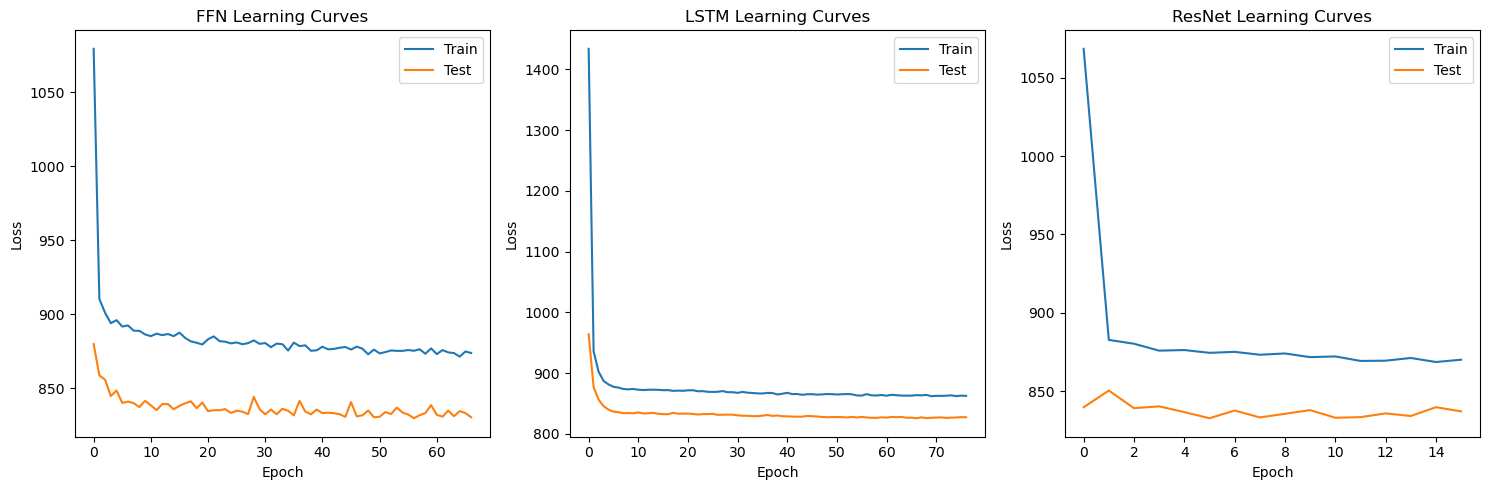

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import platform

# Check if running on M1 Mac and set device
is_m1_mac = platform.processor() == 'arm'
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

class FantasyPointsDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)
        
    def __len__(self):
        return len(self.features)
        
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

class FFNModel(nn.Module):
    def __init__(self, input_size):
        super(FFNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.model(x)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

class ResNet(nn.Module):
    def __init__(self, input_size):
        super(ResNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.res_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(128, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.BatchNorm1d(128)
            ) for _ in range(3)
        ])
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        for block in self.res_blocks:
            residual = x
            x = block(x)
            x += residual
            x = F.relu(x)
        return self.fc2(x)

def prepare_data(matches_df, ball_by_ball_df):
    """Prepare data with optimized preprocessing"""
    training_data = create_training_data(matches_df, ball_by_ball_df)
    
    feature_cols = [col for col in training_data.columns 
                   if col.startswith(('Batting_', 'Bowling_'))]
    
    X = training_data[feature_cols].values.astype(np.float32)
    y = training_data['total_points'].values.astype(np.float32)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, feature_cols

def train_model(model, X_train, y_train, X_test, y_test, 
                batch_size=32, epochs=100, learning_rate=0.001):
    """Training function with proper tensor handling"""
    train_dataset = FantasyPointsDataset(X_train, y_train)
    test_dataset = FantasyPointsDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    best_loss = float('inf')
    patience = 10
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_features, batch_targets in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Evaluation
        model.eval()
        test_loss = 0
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            for batch_features, batch_targets in test_loader:
                outputs = model(batch_features)
                test_loss += criterion(outputs, batch_targets.unsqueeze(1)).item()
                
                # Convert to Python lists instead of using numpy directly
                all_predictions.extend(outputs.squeeze().tolist())
                all_targets.extend(batch_targets.tolist())
        
        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        if avg_test_loss < best_loss:
            best_loss = avg_test_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    # Convert final predictions to numpy arrays after collecting all data
    predictions = np.array(all_predictions)
    actuals = np.array(all_targets)
    
    return model, train_losses, test_losses, predictions, actuals

def compare_models(matches_df, ball_by_ball_df):
    """Compare different model architectures"""
    X, y, feature_cols = prepare_data(matches_df, ball_by_ball_df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    models = {
        'FFN': FFNModel(len(feature_cols)),
        'LSTM': LSTMModel(len(feature_cols)),
        'ResNet': ResNet(len(feature_cols))
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name} model...")
        model, train_losses, test_losses, predictions, actuals = train_model(
            model, X_train, y_train, X_test, y_test
        )
        
        # Calculate metrics
        mse = mean_squared_error(actuals, predictions)
        mae = mean_absolute_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)
        
        results[name] = {
            'mse': mse,
            'mae': mae,
            'r2': r2,
            'train_losses': train_losses,
            'test_losses': test_losses
        }
        
        print(f"{name} Results:")
        print(f"MSE: {mse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"R2: {r2:.2f}")
    
    return results

# Example usage
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    
    results = compare_models(matches_df, ball_by_ball_df)
    
    # Plot training curves
    plt.figure(figsize=(15, 5))
    for idx, (name, result) in enumerate(results.items(), 1):
        plt.subplot(1, 3, idx)
        plt.plot(result['train_losses'], label='Train')
        plt.plot(result['test_losses'], label='Test')
        plt.title(f'{name} Learning Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    plt.tight_layout()
    plt.show()

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

class CricketDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

class DualPathAttention(nn.Module):
    def __init__(self, batting_size, bowling_size, hidden_dim):
        super().__init__()
        self.batting_attn = nn.MultiheadAttention(hidden_dim, 4, batch_first=True)
        self.bowling_attn = nn.MultiheadAttention(hidden_dim, 4, batch_first=True)
        
        self.batting_proj = nn.Linear(batting_size, hidden_dim)
        self.bowling_proj = nn.Linear(bowling_size, hidden_dim)
        
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)

    def forward(self, batting_features, bowling_features):
        batting = self.batting_proj(batting_features).unsqueeze(1)
        bowling = self.bowling_proj(bowling_features).unsqueeze(1)
        
        batting_attn, _ = self.batting_attn(batting, batting, batting)
        bowling_attn, _ = self.bowling_attn(bowling, bowling, bowling)
        
        batting_out = self.norm1(batting + batting_attn)
        bowling_out = self.norm2(bowling + bowling_attn)
        
        return batting_out.squeeze(1), bowling_out.squeeze(1)

class CricketTransformerV3(nn.Module):
    def __init__(self, batting_size=5, bowling_size=4, hidden_dim=64):
        super().__init__()
        
        self.dual_attn = DualPathAttention(batting_size, bowling_size, hidden_dim)
        
        self.interaction = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.point_predictors = nn.ModuleDict({
            'batting': nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Linear(hidden_dim // 2, 1)
            ),
            'bowling': nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Linear(hidden_dim // 2, 1)
            ),
            'fielding': nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Linear(hidden_dim // 2, 1)
            )
        })
        
        self.final_layer = nn.Linear(3, 1)
        
    def forward(self, x):
        batting_features = x[:, :5]
        bowling_features = x[:, 5:]
        
        batting_encoded, bowling_encoded = self.dual_attn(batting_features, bowling_features)
        combined = torch.cat([batting_encoded, bowling_encoded], dim=1)
        features = self.interaction(combined)
        
        points = {
            key: predictor(features) 
            for key, predictor in self.point_predictors.items()
        }
        
        all_points = torch.cat([points[k] for k in ['batting', 'bowling', 'fielding']], dim=1)
        return self.final_layer(all_points).squeeze()

def train_cricket_transformer(train_data, val_data, num_epochs=100, batch_size=32, 
                            learning_rate=0.001, patience=10):
    feature_cols = ['Batting_Balls_Faced', 'Batting_Average', 'Batting_Strike_Rate',
                   'Batting_Boundary_Rate', 'Batting_Dot_Ball_Percentage',
                   'Bowling_Balls_Bowled', 'Bowling_Economy', 'Bowling_Wickets_per_Ball',
                   'Bowling_Average']
    
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_data[feature_cols])
    val_features = scaler.transform(val_data[feature_cols])
    
    train_dataset = CricketDataset(train_features, train_data['total_points'].values)
    val_dataset = CricketDataset(val_features, val_data['total_points'].values)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = CricketTransformerV3().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss_sum = 0.0
        train_batches = 0
        
        for batch_features, batch_targets in train_loader:
            batch_features = batch_features.to(device)
            batch_targets = batch_targets.to(device)
            
            optimizer.zero_grad()
            predictions = model(batch_features)
            
            mse_loss = F.mse_loss(predictions, batch_targets)
            huber_loss = F.huber_loss(predictions, batch_targets)
            loss = 0.7 * mse_loss + 0.3 * huber_loss
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            train_loss_sum += loss.item()
            train_batches += 1
        
        # Validation phase
        model.eval()
        val_loss_sum = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for batch_features, batch_targets in val_loader:
                batch_features = batch_features.to(device)
                batch_targets = batch_targets.to(device)
                predictions = model(batch_features)
                val_loss = F.mse_loss(predictions, batch_targets)
                
                val_loss_sum += val_loss.item()
                val_batches += 1
        
        avg_train_loss = train_loss_sum / train_batches
        avg_val_loss = val_loss_sum / val_batches
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"Train Loss: {avg_train_loss:.4f}")
            print(f"Val Loss: {avg_val_loss:.4f}")
        
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_cricket_transformer.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    model.load_state_dict(torch.load('best_cricket_transformer.pth'))
    return model, scaler

def evaluate_model(model, test_data, scaler, feature_cols):
    model.eval()
    device = next(model.parameters()).device
    
    test_features = scaler.transform(test_data[feature_cols])
    test_dataset = CricketDataset(test_features, test_data['total_points'].values)
    test_loader = DataLoader(test_dataset, batch_size=64)
    
    total_mse = 0.0
    total_mae = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for batch_features, batch_targets in test_loader:
            batch_features = batch_features.to(device)
            batch_targets = batch_targets.to(device)
            batch_predictions = model(batch_features)
            
            mse = F.mse_loss(batch_predictions, batch_targets, reduction='sum')
            mae = F.l1_loss(batch_predictions, batch_targets, reduction='sum')
            
            total_mse += mse.item()
            total_mae += mae.item()
            total_samples += batch_targets.size(0)
    
    mse = total_mse / total_samples
    mae = total_mae / total_samples
    
    return {
        'MSE': mse,
        'MAE': mae,
        'samples': total_samples
    }

In [77]:
# Split your data
from sklearn.model_selection import train_test_split

# First split into train and temp
train_data, temp_data = train_test_split(training_data, test_size=0.3, random_state=42)
# Split temp into val and test
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Train model
model, scaler = train_cricket_transformer(
    train_data, 
    val_data, 
    num_epochs=100,
    batch_size=32,
    learning_rate=0.001
)

# Evaluate
feature_cols = ['Batting_Balls_Faced', 'Batting_Average', 'Batting_Strike_Rate',
                'Batting_Boundary_Rate', 'Batting_Dot_Ball_Percentage',
                'Bowling_Balls_Bowled', 'Bowling_Economy', 'Bowling_Wickets_per_Ball',
                'Bowling_Average']

results = evaluate_model(model, test_data, scaler, feature_cols)
print(f"\nTest Results:")
print(f"MSE: {results['MSE']:.2f}")
print(f"MAE: {results['MAE']:.2f}")
print(f"Number of samples: {results['samples']}")

Using device: mps
Epoch [10/100]
Train Loss: 629.5687
Val Loss: 893.5570
Epoch [20/100]
Train Loss: 625.9796
Val Loss: 883.9530
Epoch [30/100]
Train Loss: 623.9598
Val Loss: 881.2915
Early stopping at epoch 36

Test Results:
MSE: 803.34
MAE: 22.27
Number of samples: 2938


In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler

class SequenceDataset(Dataset):
    def __init__(self, data, sequence_length=5):
        """
        data: DataFrame with columns ['player', 'match_id', 'batting_points', 
                                    'bowling_points', 'fielding_points']
        sequence_length: number of past matches to use for prediction
        """
        self.sequences = []
        self.targets = []
        
        # Convert to numpy first for easier manipulation
        points_columns = ['batting_points', 'bowling_points', 'fielding_points']
        
        # Group by player
        for _, player_data in data.groupby('player'):
            # Sort by match_id to maintain temporal order
            player_data = player_data.sort_values('match_id')
            
            # Get points data
            points = player_data[points_columns].values
            
            # Create sequences
            for i in range(len(points) - sequence_length):
                self.sequences.append(points[i:i+sequence_length])
                self.targets.append(points[i+sequence_length])
        
        # Convert to numpy arrays first
        self.sequences = np.array(self.sequences)
        self.targets = np.array(self.targets)
        
        # Scale the data
        self.scaler = StandardScaler()
        
        # Fit scaler on training data only
        train_sequences = self.sequences[:int(0.8 * len(self.sequences))]
        self.scaler.fit(train_sequences.reshape(-1, train_sequences.shape[-1]))
        
        # Scale all sequences and targets
        scaled_sequences = self.scaler.transform(self.sequences.reshape(-1, self.sequences.shape[-1]))
        self.sequences = scaled_sequences.reshape(self.sequences.shape)
        self.targets = self.scaler.transform(self.targets)
        
        # Convert to tensors
        self.sequences = torch.FloatTensor(self.sequences)
        self.targets = torch.FloatTensor(self.targets)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

class PointsPredictor(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, num_layers=2, dropout=0.2):
        super().__init__()
        
        # LSTM for sequence processing
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(hidden_size, 4, batch_first=True)
        
        # Point type specific layers
        self.point_processors = nn.ModuleDict({
            'batting': nn.Sequential(
                nn.Linear(hidden_size, hidden_size // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_size // 2, 1)
            ),
            'bowling': nn.Sequential(
                nn.Linear(hidden_size, hidden_size // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_size // 2, 1)
            ),
            'fielding': nn.Sequential(
                nn.Linear(hidden_size, hidden_size // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_size // 2, 1)
            )
        })
        
    def forward(self, x):
        # Process sequence through LSTM
        lstm_out, _ = self.lstm(x)
        
        # Apply attention to LSTM output
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        # Get final timestep representation
        final_hidden = attn_out[:, -1]
        
        # Generate predictions for each point type
        predictions = []
        for processor in self.point_processors.values():
            point_pred = processor(final_hidden)
            predictions.append(point_pred)
        
        # Combine predictions
        return torch.cat(predictions, dim=1)

def train_predictor(train_data, val_data, sequence_length=5, num_epochs=100, batch_size=32):
    # Create datasets
    train_dataset = SequenceDataset(train_data, sequence_length)
    val_dataset = SequenceDataset(val_data, sequence_length)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model and training components
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = PointsPredictor().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.01,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader)
    )
    
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss_sum = 0
        
        for sequences, targets in train_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            predictions = model(sequences)
            
            # Combined loss for all point types
            loss = F.mse_loss(predictions, targets)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            
            train_loss_sum += loss.item()
        
        # Validation phase
        model.eval()
        val_loss_sum = 0
        
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences = sequences.to(device)
                targets = targets.to(device)
                
                predictions = model(sequences)
                val_loss = F.mse_loss(predictions, targets)
                val_loss_sum += val_loss.item()
        
        avg_train_loss = train_loss_sum / len(train_loader)
        avg_val_loss = val_loss_sum / len(val_loader)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"Train Loss: {avg_train_loss:.4f}")
            print(f"Val Loss: {avg_val_loss:.4f}")
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_points_predictor.pth')
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(torch.load('best_points_predictor.pth'))
    return model, train_dataset.scaler

def evaluate_predictor(model, test_data, scaler, sequence_length=5):
    model.eval()
    device = next(model.parameters()).device
    
    test_dataset = SequenceDataset(test_data, sequence_length)
    test_loader = DataLoader(test_dataset, batch_size=64)
    
    total_mse = 0
    total_mae = 0
    total_samples = 0
    
    # Track errors by point type
    point_type_errors = {
        'batting': {'mse': 0, 'mae': 0},
        'bowling': {'mse': 0, 'mae': 0},
        'fielding': {'mse': 0, 'mae': 0}
    }
    
    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            
            predictions = model(sequences)
            
            # Overall metrics
            mse = F.mse_loss(predictions, targets, reduction='sum')
            mae = F.l1_loss(predictions, targets, reduction='sum')
            
            total_mse += mse.item()
            total_mae += mae.item()
            total_samples += targets.size(0)
            
            # Per point type metrics
            for i, point_type in enumerate(['batting', 'bowling', 'fielding']):
                point_mse = F.mse_loss(predictions[:, i], targets[:, i], reduction='sum')
                point_mae = F.l1_loss(predictions[:, i], targets[:, i], reduction='sum')
                point_type_errors[point_type]['mse'] += point_mse.item()
                point_type_errors[point_type]['mae'] += point_mae.item()
    
    # Calculate final metrics
    results = {
        'overall': {
            'MSE': total_mse / total_samples,
            'MAE': total_mae / total_samples
        }
    }
    
    for point_type in point_type_errors:
        results[point_type] = {
            'MSE': point_type_errors[point_type]['mse'] / total_samples,
            'MAE': point_type_errors[point_type]['mae'] / total_samples
        }
    
    results['samples'] = total_samples
    return results

In [97]:
# First, make sure your data is sorted by match_id within each player
training_data = training_data.sort_values(['player', 'match_id'])

# Split data temporally - use earlier matches for training
match_ids = training_data['match_id'].unique()
train_matches = match_ids[:int(len(match_ids)*0.6)]
val_matches = match_ids[int(len(match_ids)*0.6):int(len(match_ids)*0.8)]
test_matches = match_ids[int(len(match_ids)*0.8):]

train_data = training_data[training_data['match_id'].isin(train_matches)]
val_data = training_data[training_data['match_id'].isin(val_matches)]
test_data = training_data[training_data['match_id'].isin(test_matches)]

# Train model
model, scaler = train_predictor(train_data, val_data, sequence_length=5)

# Evaluate
results = evaluate_predictor(model, test_data, scaler)
print("\nTest Results:")
print(f"Overall MSE: {results['overall']['MSE']:.2f}")
print(f"Overall MAE: {results['overall']['MAE']:.2f}")
print("\nBreakdown by point type:")
for point_type in ['batting', 'bowling', 'fielding']:
    print(f"\n{point_type.title()} Points:")
    print(f"MSE: {results[point_type]['MSE']:.2f}")
    print(f"MAE: {results[point_type]['MAE']:.2f}")

Using device: mps
Epoch [10/100]
Train Loss: 0.8207
Val Loss: 0.7998
Early stopping at epoch 14

Test Results:
Overall MSE: 2.60
Overall MAE: 2.11

Breakdown by point type:

Batting Points:
MSE: 0.87
MAE: 0.68

Bowling Points:
MSE: 0.78
MAE: 0.67

Fielding Points:
MSE: 0.95
MAE: 0.76
